In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from omegaconf import OmegaConf
from src.models import models
from src.models import model as mainmodel
from src.models import modelConv2d
from src.models import modelineal
from src.models import decoders
from src import loss_func
from src import train
from src import loader
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from src import optimizer_Factory as of
import Data.genData as genData
from src import custom_plots as cp
from src import Visual_utils as vu
import torchvision
import wandb
import random
import os

from scipy.signal import savgol_filter


os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:2000"
torch.cuda.empty_cache() 
torch.manual_seed(42)

## Custom intensity

### Create video

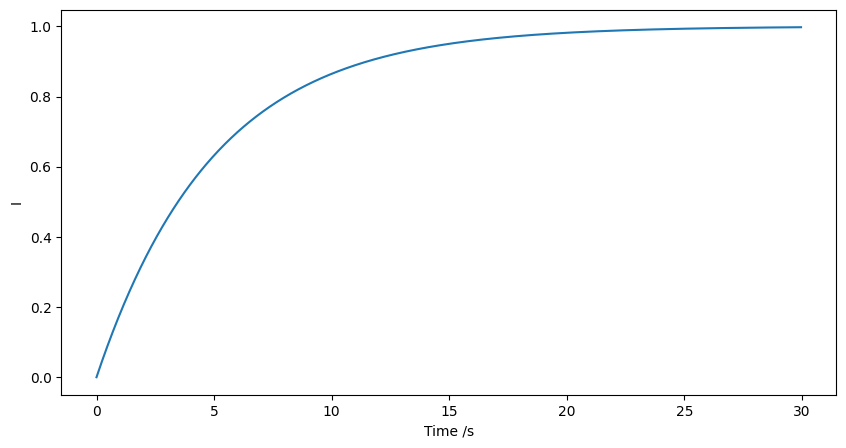

In [2]:
dt = 0.1
t = np.arange(0, 30, 1/30)
I = -np.exp(-t * 0.2) +1
plt.figure(figsize=(10, 5))
plt.plot(t, I)
plt.xlabel('Time /s')
plt.ylabel('I')
plt.show()


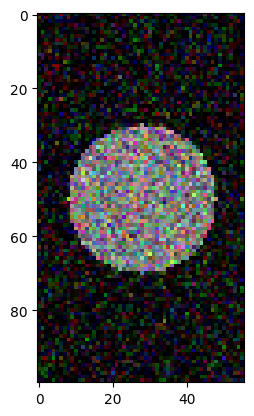

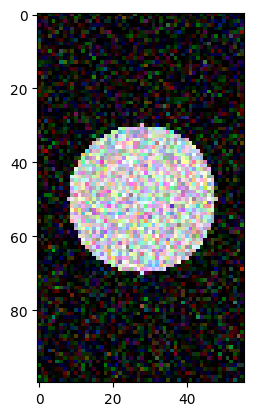

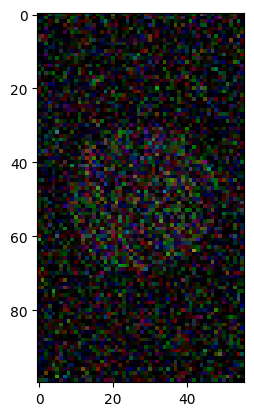

In [3]:
import cv2
def create_circle_image(I):
    # Create a black image
    img = np.zeros((100,56,3), np.uint8)
    # Draw a circle
    cv2.circle(img, (28,50), 20, (int(I*255),int(I*255),int(I*255)), -1)   

    # Add some noise outside the circle
    noise = np.random.normal(0, 44, img.shape)
    
    #mask = np.zeros((100,56), np.uint8)
    #cv2.circle(mask, (28,50), 20, 255, -1)
    #mask = cv2.bitwise_not(mask)

    img = img + noise
    #img = img * mask[:,:,None] 
    
    img = np.clip(img, 0, 255)

    img = img.astype(np.uint8)

    # To gray scale

    #print(img.shape)

    #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  

    # Return the image
    return img


# test frame
img = create_circle_image(0.5)
plt.imshow(img, cmap='gray')
plt.show()


# test frame
img = create_circle_image(0.8)
plt.imshow(img, cmap='gray')
plt.show()

# test frame
img = create_circle_image(0.1)
plt.imshow(img, cmap='gray')
plt.show()





In [4]:
# Create a video
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('output.avi', fourcc, 30.0, (56, 100))

for i in I:
    img = create_circle_image(i)
    out.write(img)

out.release()


### process video

In [5]:
import cv2

# load video from folder using opencv


video = cv2.VideoCapture('./output.avi')
new_width, new_height = 56,100


new_dim = (new_width, new_height)

frames = []
while True:
    ret, frame = video.read()
    
    if ret == False:
        break
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    resized_img = cv2.resize(frame, new_dim, interpolation= cv2.INTER_CUBIC )
    #resized_img = frame
    frames.append(resized_img)
video.release()

print(len(frames))

video = cv2.VideoCapture('./output.avi')
# Find OpenCV version
(major_ver, minor_ver, subminor_ver) = (cv2.__version__).split('.')

# With webcam get(CV_CAP_PROP_FPS) does not work.
# Let's see for ourselves.

if int(major_ver)  < 3 :
    fps = video.get(cv2.cv.CV_CAP_PROP_FPS)
    print("Frames per second using video.get(cv2.cv.CV_CAP_PROP_FPS): {0}".format(fps))
else :
    fps = video.get(cv2.CAP_PROP_FPS)
    print("Frames per second using video.get(cv2.CAP_PROP_FPS) : {0}".format(fps))

900
Frames per second using video.get(cv2.CAP_PROP_FPS) : 30.0


120


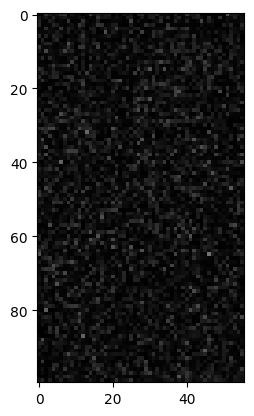

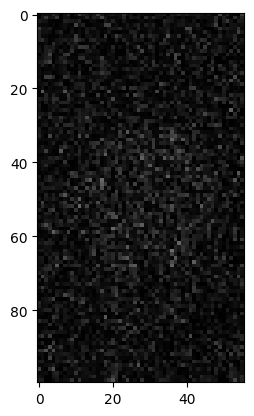

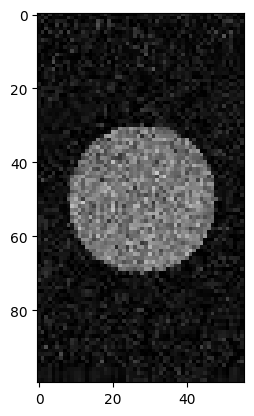

In [6]:
np_frames = np.array(frames)
init = 0
fps = 60
period = 2*fps
print(period)
period = int(period)


plt.imshow(np_frames[2], cmap='gray', vmax=255, vmin=0)
plt.show()

plt.imshow(np_frames[10], cmap='gray', vmax=255, vmin=0)
plt.show()
plt.imshow(np_frames[100], cmap='gray', vmax=255, vmin=0)
plt.show()

In [7]:
dataset = []
np_frames = np.array(frames)
np_frames = np_frames
print(np_frames.shape)
np_frames = np_frames / 255.0
print("number of frames:", np_frames.shape)
nframes = np_frames.shape[0]
step = 3
max_frames = np_frames.shape[0] - (20*step)
for i in range(max_frames):

    frames_temp = np_frames[i:(i+20*step):step]
    
    dataset.append(np.expand_dims( frames_temp, axis=1))

print(len(dataset))

(900, 100, 56)
number of frames: (900, 100, 56)
840


In [8]:
np.save('Data/Data_rebuttal/customI4.npy', dataset)

### evaluate data

In [3]:
data_folder = np.load('Data/Data_rebuttal/customI4.npy', allow_pickle=True)

(840, 20, 1, 100, 56)


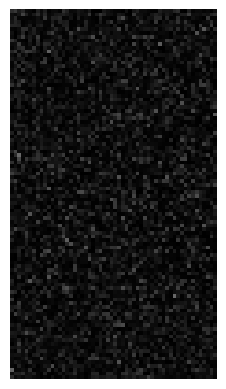

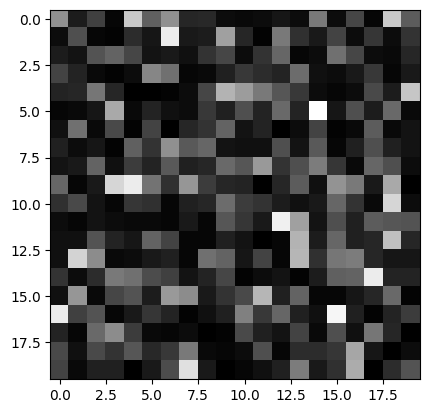

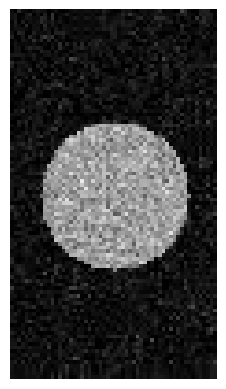

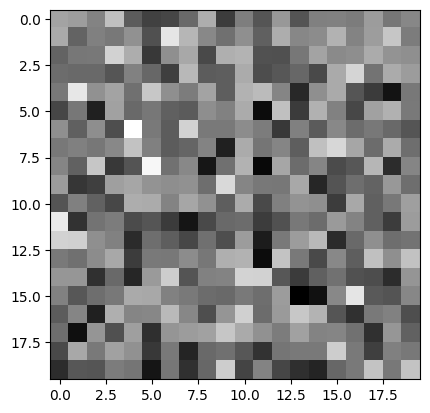

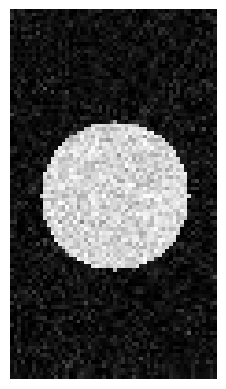

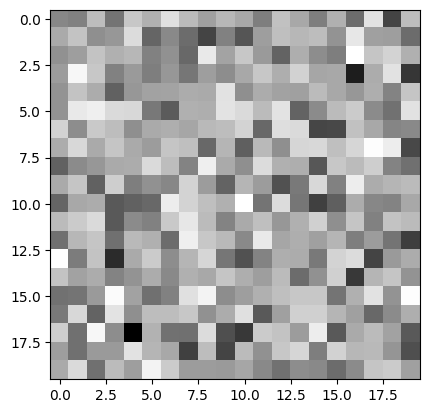

In [4]:
print(data_folder.shape)

for i in range(3):
    plt.imshow(data_folder[i*150][0][0], cmap='gray', vmax=1, vmin=0)
    
    #save imge
    plt.axis('off')

    

    plt.savefig('./Figures/Rebuttal/customI/frame'+str(i)+'.png')

    plt.show()
    
    sub_image = data_folder[i*150,0,0, 40:60, 15:35]
    plt.imshow(sub_image, cmap='gray')
    plt.show()




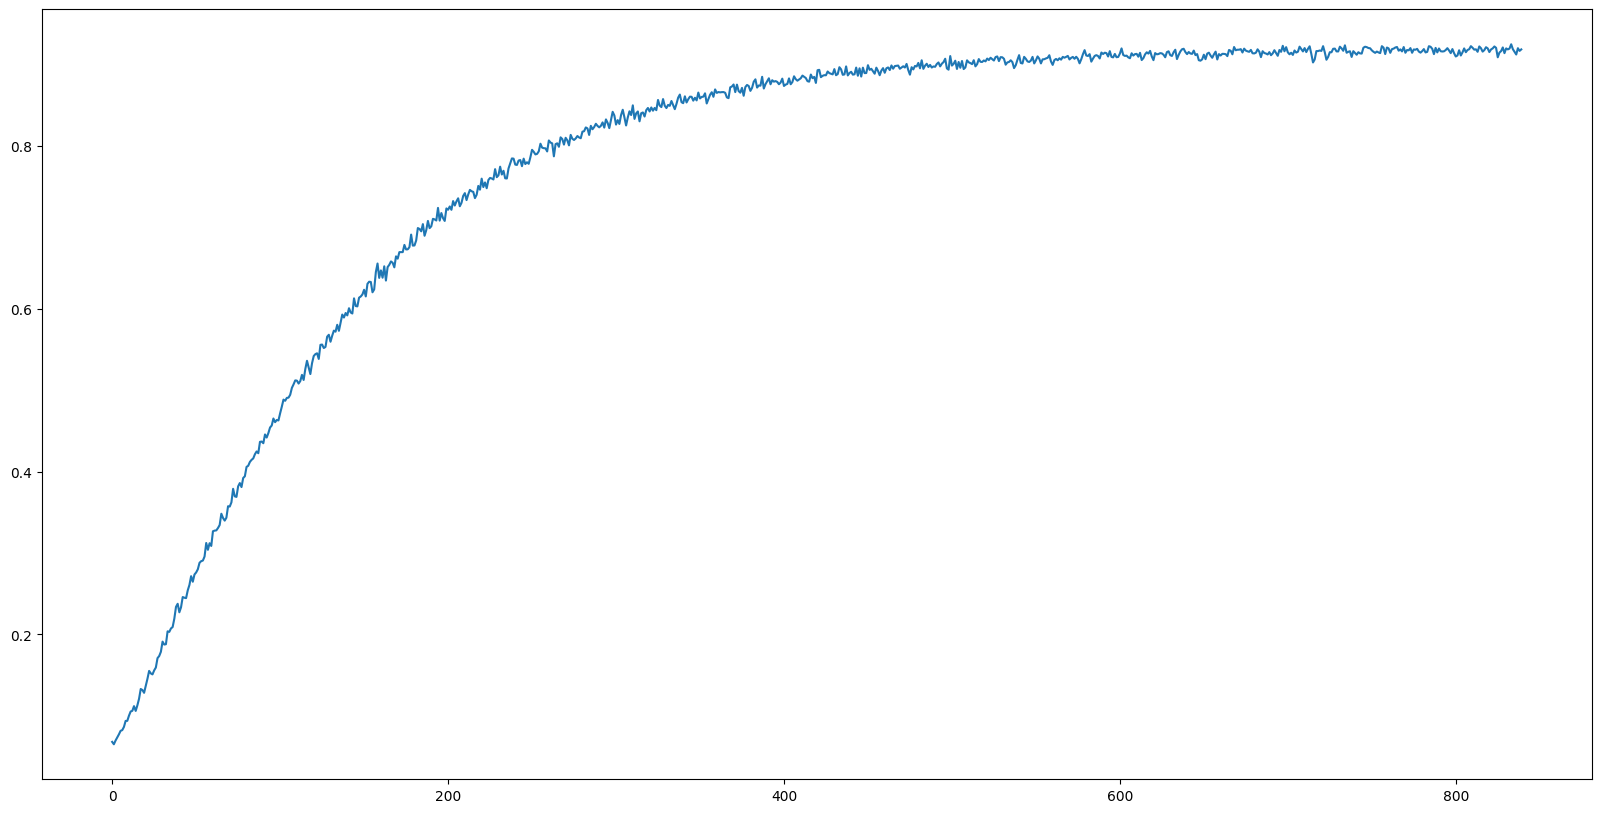

In [11]:
mean_list = []
for i in range(data_folder.shape[0]):
    mean_list.append(np.mean(data_folder[i,0,0, 40:60, 15:35]))
plt.figure(figsize=(20,10))
plt.plot(mean_list)
plt.show()

### Model

In [12]:
torch.cuda.empty_cache() 
torch.manual_seed(42)


data_folder = np.load('Data/Data_rebuttal/customI4.npy', allow_pickle=True)
data_train = data_folder
# print max
print(np.max(data_train))
print(data_train.shape)

dt = 3/30
train_dataloader, test_dataloader, train_x, val_x  = loader.getLoader_folder(data_train, split=True)




latentEncoder_I = mainmodel.EndPhys(dt = dt,
                                pmodel = "dyn_1storder",
                                init_phys = 1.0, 
                                initw=True)

latentEncoder_I, log, params  = train.train(latentEncoder_I, 
                                train_dataloader, 
                                test_dataloader,
                                init_phys = 0.1,                                 
                                loss_name='latent_loss')

1.0
(840, 20, 1, 100, 56)


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


dt 0.1
Using device: cuda


wandb: Currently logged in as: alejandro_c. Use `wandb login --relogin` to force relogin


Initial Loss 	 training loss: 4.1649073759714765 	 validation loss: 4.7232561111450195
epoch: 25 	 training loss: 0.023142163719361026 	 validation loss: 2.8009748458862305
epoch: 50 	 training loss: 0.05813129432499409 	 validation loss: 3.3443480730056763
epoch: 75 	 training loss: 0.027717608958482742 	 validation loss: 3.652127981185913
epoch: 100 	 training loss: 0.03922697063535452 	 validation loss: 5.840134382247925
epoch: 125 	 training loss: 0.06564397411420941 	 validation loss: 2.3581990003585815
epoch: 150 	 training loss: 0.018095596072574455 	 validation loss: 5.974330186843872
epoch: 175 	 training loss: 0.01870628089333574 	 validation loss: 2.485845446586609
epoch: 200 	 training loss: 0.026314362495516736 	 validation loss: 3.9190512895584106
epoch: 225 	 training loss: 0.023867742779354256 	 validation loss: 3.3704042434692383
epoch: 250 	 training loss: 0.014681440390025577 	 validation loss: 5.765294313430786
best model a 0.22612713277339935
best last a 0.21734347

In [13]:
dataloader  = loader.getLoader_folder(data_train, split=False)

z = None

device = "cuda" if torch.cuda.is_available() else "cpu"

best_model = mainmodel.EndPhys(dt = dt,
                    pmodel = "dyn_1storder",
                    init_phys = 1.0, 
                    initw=True)

checkpoint = torch.load('best-model-parameters.pt')
#checkpoint = torch.load('best-train-parameters.pt')
best_model.load_state_dict(checkpoint)
best_model.to(device)

z = None
X = []

for data in dataloader:

    input_Data, out_Data = data

    x0 = input_Data

    x0 = x0.to(device=device, dtype=torch.float)

    x2 = out_Data.to(device=device, dtype=torch.float)

    outputs = best_model(x0)
    #outputs = latentEncoder_I(x0)
    z2_encoder, z2_phys, z3=outputs

    if z is None:
        z = z2_encoder.detach().cpu().numpy()[0][0]
    else:
        z = np.vstack((z,z2_encoder.detach().cpu().numpy()[0][0]))

dt 0.1


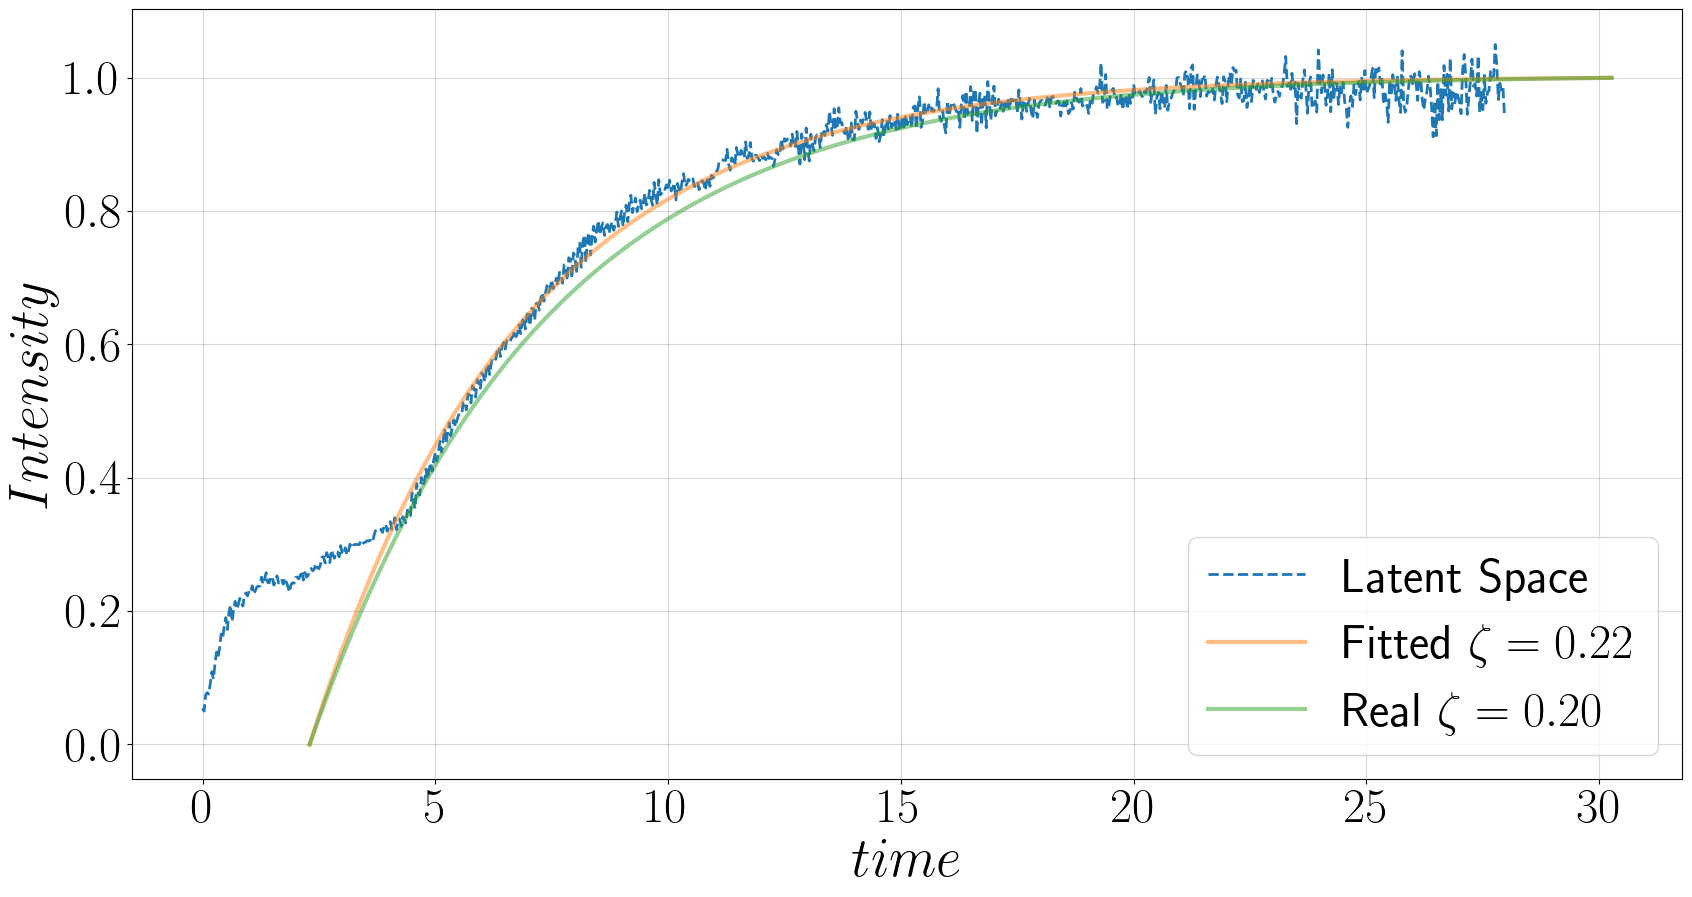

In [22]:
def exp2fit(x, a, b, c):
    return a * np.exp(-b * x) +c

def normalize(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))

time = np.arange(z.shape[0])/30
z_fit = exp2fit(time, -1, 0.2, 0)
z_fit2 = exp2fit(time, -1, 0.22, 0)

time = time
z_norm = -z
z_fit = z_fit

ys_crop = mean_list

z_norm = normalize(z_norm)
z_fit = normalize(z_fit)
z_fit2 = normalize(z_fit2)

ys_crop = normalize(ys_crop)


time_crop = time

plt.figure(figsize=(20,10))
plt.rcParams['text.usetex'] = True
plt.plot(time, z_norm+0.05,'--', label=r'Latent Space', linewidth=2 )
plt.plot(time+2.3, z_fit2, label=r'Fitted $ \zeta = 0.22$', linewidth=3, alpha=0.5) 
plt.plot(time+2.3, z_fit, label=r'Real $ \zeta = 0.20$', linewidth=3, alpha=0.5) 
plt.legend(fontsize="35")
plt.xlabel(r'$time$', fontsize=40)
plt.ylabel(r'$Intensity$', fontsize=40)
plt.tick_params(axis='y', which='major')#, pad=25)
plt.rc('xtick', labelsize=35)
plt.rc('ytick', labelsize=35)
plt.grid(True, alpha=0.5)

plt.savefig('Data/Data_rebuttal/fit_customI.png', dpi = 300)

plt.show()

## Led experiment

### Data Creation

In [6]:
import cv2

# load video from folder using opencv

video = cv2.VideoCapture('Data/Data_rebuttal/Led.mov')

new_width, new_height = 100,56


new_dim = (new_width, new_height)

frames = []
index = 0
while True:
    ret, frame = video.read()
    
    if ret == False:
        break

    if index in [20,70,120]:
        #save image and resized image
        cv2.imwrite(f'./Figures/Rebuttal/frame_{index}_led.png', frame)
        resized_img = cv2.resize(frame, new_dim, interpolation= cv2.INTER_CUBIC )
        cv2.imwrite(f'./Figures/Rebuttal/frame_{index}_resized_led_color.png', resized_img)
        resized_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2GRAY)
        cv2.imwrite(f'./Figures/Rebuttal/frame_{index}_resized_led.png', resized_img)

    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    resized_img = cv2.resize(frame, new_dim, interpolation= cv2.INTER_CUBIC )
    #resized_img = frame
    frames.append(resized_img)

    index += 1
video.release()

print(len(frames))



243


In [7]:
video = cv2.VideoCapture('Data/Data_rebuttal/Led.mov')
# Find OpenCV version
(major_ver, minor_ver, subminor_ver) = (cv2.__version__).split('.')

# With webcam get(CV_CAP_PROP_FPS) does not work.
# Let's see for ourselves.

if int(major_ver)  < 3 :
    fps = video.get(cv2.cv.CV_CAP_PROP_FPS)
    print("Frames per second using video.get(cv2.cv.CV_CAP_PROP_FPS): {0}".format(fps))
else :
    fps = video.get(cv2.CAP_PROP_FPS)
    print("Frames per second using video.get(cv2.CAP_PROP_FPS) : {0}".format(fps))

Frames per second using video.get(cv2.CAP_PROP_FPS) : 29.97002997002997


120


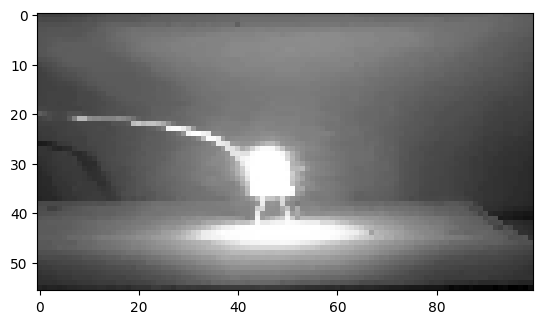

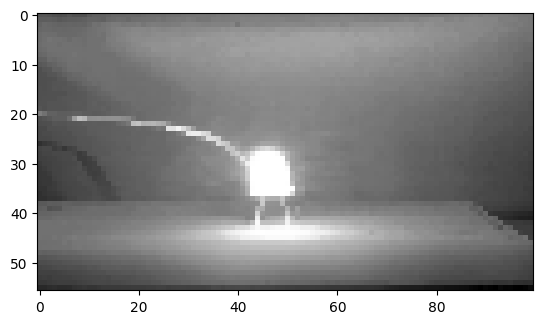

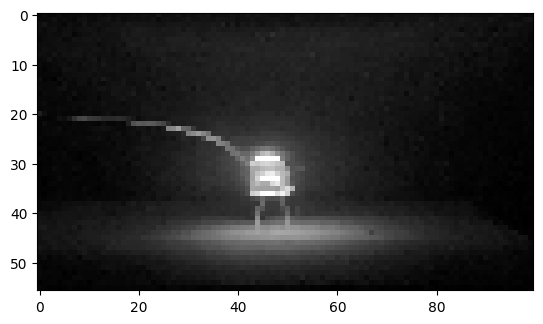

In [8]:
np_frames = np.array(frames)
init = 0
fps = 60
period = 2*fps
print(period)
period = int(period)


plt.imshow(np_frames[0], cmap='gray')
plt.show()

plt.imshow(np_frames[10], cmap='gray')
plt.show()
plt.imshow(np_frames[120], cmap='gray')
plt.show()

(243, 56, 100)


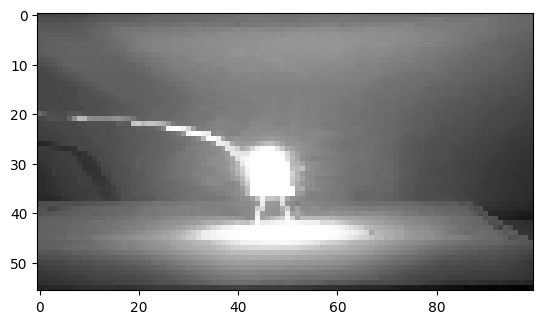

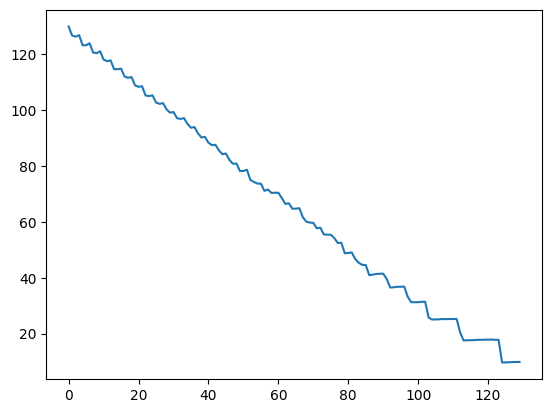

In [9]:
np_frames = np.array(frames)
print(np_frames.shape)

sub_image = np_frames[1]
plt.imshow(sub_image, cmap='gray')
plt.show()

mean_list = []
for i in range(0, np_frames.shape[0]):
    sub_image = np_frames[i]
    mean_list.append(np.mean(sub_image))

plt.plot(mean_list[20:150])
plt.show()


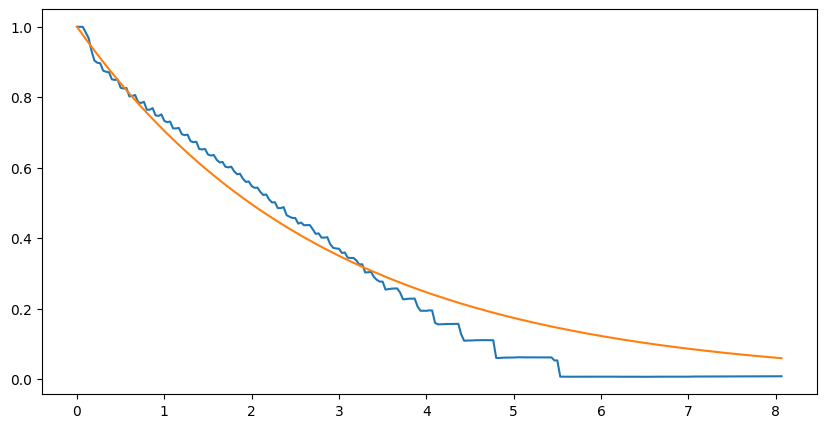

In [10]:
import scipy.optimize
def monoExp(x, m, t, b):
    return m * np.exp(-t * x) + b

#mean_list = mean_list[20:300]
mean_list = mean_list
xs = np.arange(0, len(mean_list))
xs = xs/30
ys = mean_list/ np.max(mean_list)
y_exp = monoExp(xs, 1, 0.35,0 )
plt.figure( figsize=(10, 5))
plt.plot(xs, ys)
plt.plot(xs, y_exp)
plt.show()




In [16]:
dataset = []
np_frames = np.array(frames)
np_frames = np_frames[20:150]
print(np_frames.shape)
np_frames = np_frames / 255.0
print("number of frames:", np_frames.shape)
nframes = np_frames.shape[0]
step = 3
max_frames = np_frames.shape[0] - (10*step)
for i in range(max_frames):

    frames_temp = np_frames[i:(i+10*step):step]
    
    dataset.append(np.expand_dims( frames_temp, axis=1))

print(len(dataset))

(130, 56, 100)
number of frames: (130, 56, 100)
100


In [9]:
np.save('Data/Data_rebuttal/Led.npy', dataset)

### Model

In [11]:
torch.cuda.empty_cache() 
torch.manual_seed(0)


data_folder = np.load('Data/Data_rebuttal/Led.npy', allow_pickle=True)
data_train = data_folder
print(data_train.shape)

dt = 3/30
train_dataloader, test_dataloader, train_x, val_x  = loader.getLoader_folder(data_train, split=True)




latentEncoder_I = mainmodel.EndPhys(dt = dt,
                                pmodel = "lineal",
                                init_phys = 1.0, 
                                initw=True)

latentEncoder_I, log, params  = train.train(latentEncoder_I, 
                                train_dataloader, 
                                test_dataloader,
                                init_phys = 1.0,                                 
                                loss_name='latent_loss')

(100, 10, 1, 56, 100)
dt 0.1
Using device: cuda


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: alejandro_c. Use `wandb login --relogin` to force relogin


Initial Loss 	 training loss: 4.877853870391846 	 validation loss: 6.622964382171631
epoch: 25 	 training loss: 1.62703275680542 	 validation loss: 1.887648105621338
epoch: 50 	 training loss: 0.681587278842926 	 validation loss: 2.411294937133789
epoch: 75 	 training loss: 0.006742030382156372 	 validation loss: 1.7344417572021484
epoch: 100 	 training loss: 0.003565409453585744 	 validation loss: 1.816431999206543
epoch: 125 	 training loss: 0.002969633787870407 	 validation loss: 1.8844400644302368
epoch: 150 	 training loss: 0.0027087596245110035 	 validation loss: 1.962154507637024
epoch: 175 	 training loss: 0.0024552710819989443 	 validation loss: 2.044114828109741
epoch: 200 	 training loss: 0.002298997947946191 	 validation loss: 2.1231820583343506
epoch: 225 	 training loss: 0.0022487686946988106 	 validation loss: 2.1574909687042236
epoch: 250 	 training loss: 0.0022180320229381323 	 validation loss: 2.1787796020507812
best model a -0.09831766784191132
best last a 1.19793999

In [12]:
dataloader  = loader.getLoader_folder(data_train, split=False)

z = None

device = "cuda" if torch.cuda.is_available() else "cpu"

best_model = mainmodel.EndPhys(dt = dt,
                    pmodel = "lineal",
                    init_phys = 1.0, 
                    initw=True)

checkpoint = torch.load('best-model-parameters.pt')
best_model.load_state_dict(checkpoint)
best_model.to(device)

z = None
X = []

for data in dataloader:

    input_Data, out_Data = data

    x0 = input_Data

    x0 = x0.to(device=device, dtype=torch.float)

    x2 = out_Data.to(device=device, dtype=torch.float)

    outputs = best_model(x0)
    #outputs = latentEncoder_I(x0)
    z2_encoder, z2_phys, z3=outputs

    if z is None:
        z = z2_encoder.detach().cpu().numpy()[0][0]
    else:
        z = np.vstack((z,z2_encoder.detach().cpu().numpy()[0][0]))

dt 0.1


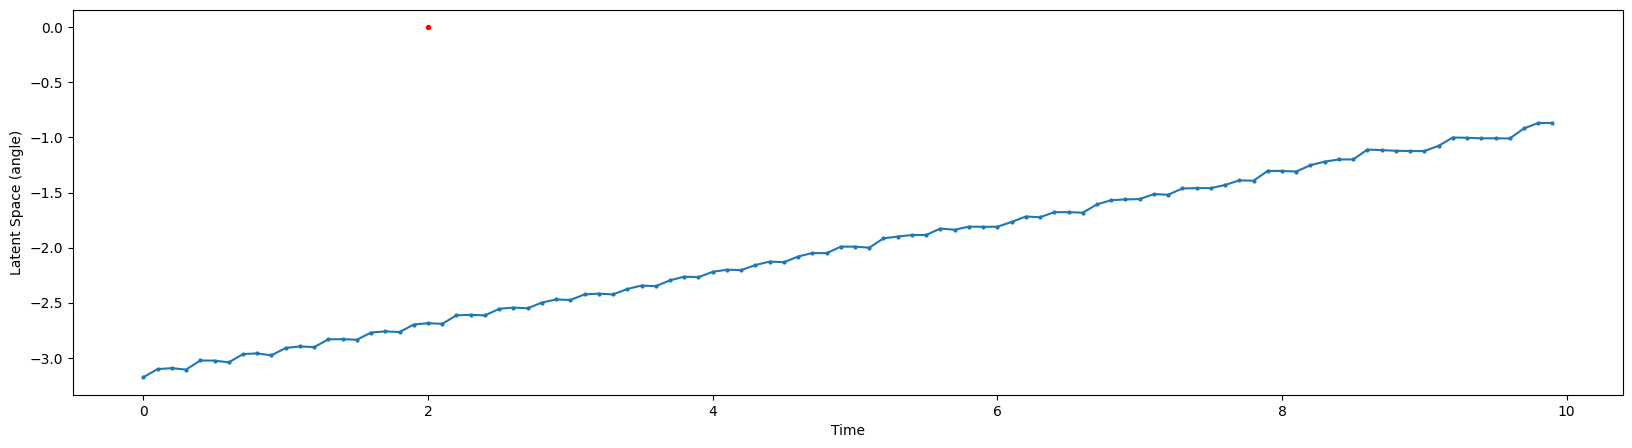

In [13]:
plt.figure(figsize=(20,5))
time = np.arange(z.shape[0])
plt.scatter(time*dt, z, label='real',s=4)
plt.plot(time*dt, z, label='real')
plt.scatter(2.0, 0, color = "red",s=8)
plt.xlabel('Time')
plt.ylabel('Latent Space (angle)')
plt.show()

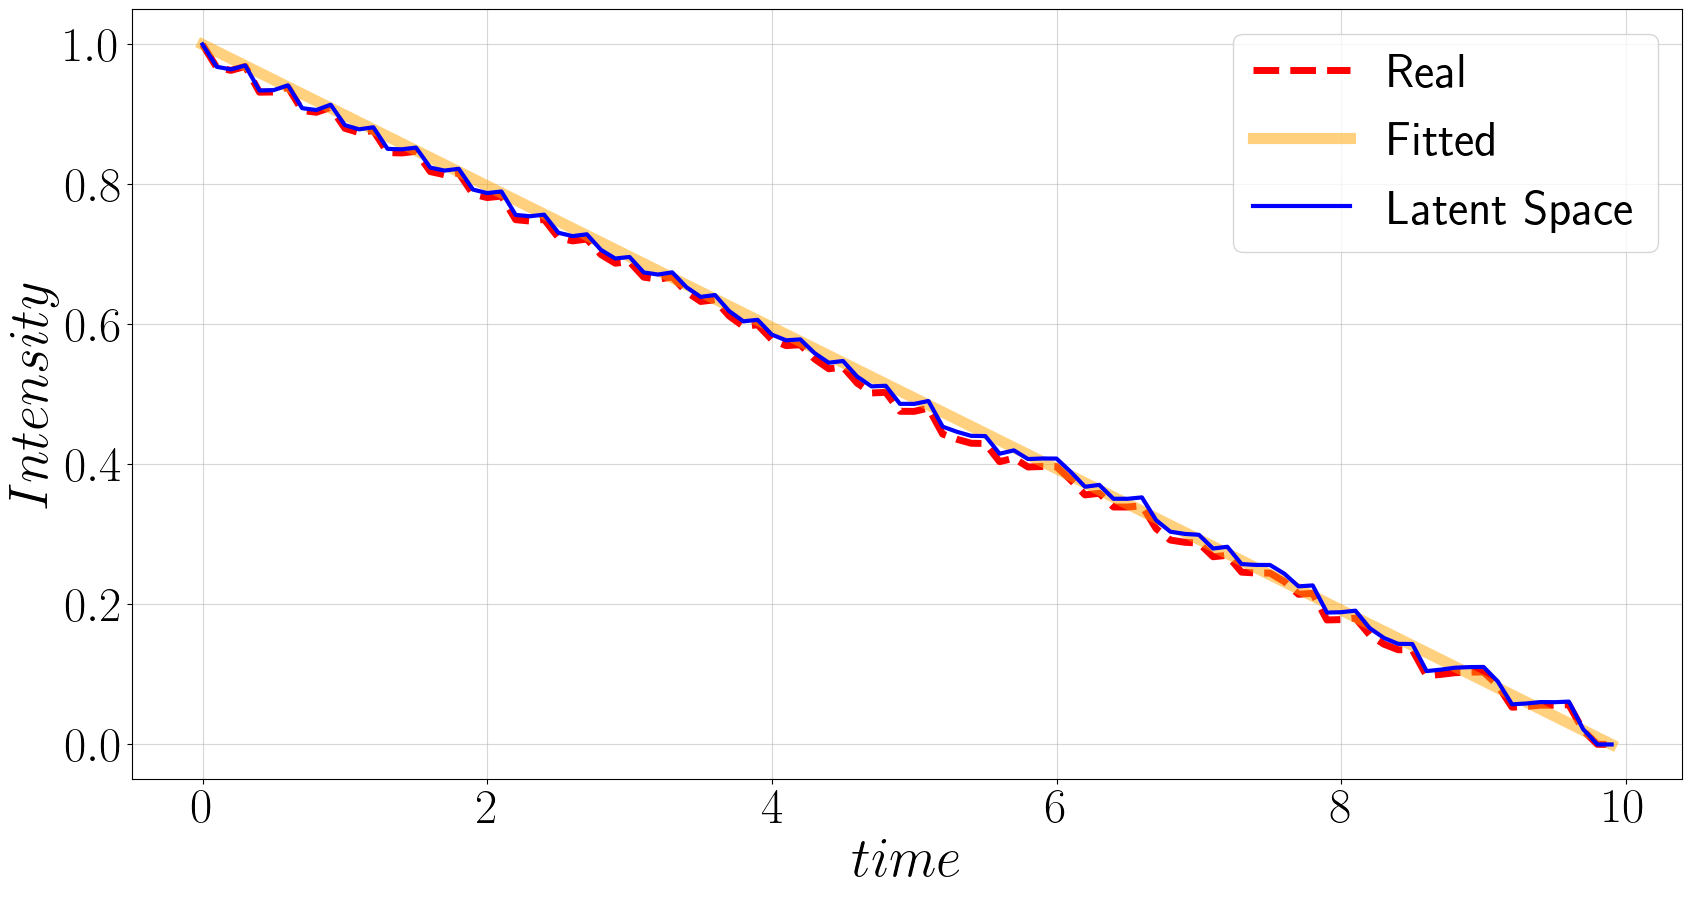

In [26]:
def exp2fit(x, a, b, c):
    return a * np.exp(-b * x) +c

def lineal2fit(x, a):
    return -x*a


def normalize(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))

time = np.arange(z.shape[0])*dt
z_fit = lineal2fit(time, 1.0)


time = time
z_norm = -z
z_fit = z_fit

ys_crop = ys[20:120]

z_norm = normalize(z_norm)
z_fit = normalize(z_fit)
ys_crop = normalize(ys_crop)

time_crop = time

plt.figure(figsize=(20,10))
plt.rcParams['text.usetex'] = True

plt.plot( time_crop,ys_crop,'--', color = 'red', label=r'Real', linewidth=5) 
plt.plot(time, z_fit, color = 'orange', label=r'Fitted', linewidth=8, alpha=0.5) 
plt.plot(time, z_norm,'-', color = 'b' , label=r'Latent Space', linewidth=3 )
plt.legend(fontsize="35")
plt.xlabel(r'$time$', fontsize=40)
plt.ylabel(r'$Intensity$', fontsize=40)
plt.tick_params(axis='y', which='major')#, pad=25)
plt.rc('xtick', labelsize=35)
plt.rc('ytick', labelsize=35)
plt.grid(True, alpha=0.5)
plt.savefig('Data/Data_rebuttal/fit_led.png', dpi = 300)
plt.show()

## Real pendulum

### Data Gen

In [3]:
import cv2

# load video from folder using opencv

video = cv2.VideoCapture('Data/Data_rebuttal/pendulum_120_4.mp4')

new_width, new_height = 100,56


new_dim = (new_width, new_height)

frames = []
index = 0
while True:
    ret, frame = video.read()
    
    if ret == False:
        break
    if index in [20,70,120]:
        #save image and resized image
        cv2.imwrite(f'./Figures/Rebuttal/frame_{index}_pendulum.png', frame)
        resized_img = cv2.resize(frame, new_dim, interpolation= cv2.INTER_CUBIC )
        cv2.imwrite(f'./Figures/Rebuttal/frame_{index}_resized_pendulum_color.png', resized_img)
        resized_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2GRAY)
        cv2.imwrite(f'./Figures/Rebuttal/frame_{index}_resized_pendulum.png', resized_img)

    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    resized_img = cv2.resize(frame, new_dim, interpolation= cv2.INTER_AREA)
    frames.append(resized_img)
    index += 1
video.release()

print(len(frames))



2711


In [4]:

video = cv2.VideoCapture('Data/Data_rebuttal/pendulum_120_4.mp4')
# Find OpenCV version
(major_ver, minor_ver, subminor_ver) = (cv2.__version__).split('.')

# With webcam get(CV_CAP_PROP_FPS) does not work.
# Let's see for ourselves.

if int(major_ver)  < 3 :
    fps = video.get(cv2.cv.CV_CAP_PROP_FPS)
    print("Frames per second using video.get(cv2.cv.CV_CAP_PROP_FPS): {0}".format(fps))
else :
    fps = video.get(cv2.CAP_PROP_FPS)
    print("Frames per second using video.get(cv2.CAP_PROP_FPS) : {0}".format(fps))
 

Frames per second using video.get(cv2.CAP_PROP_FPS) : 59.94005994005994


120


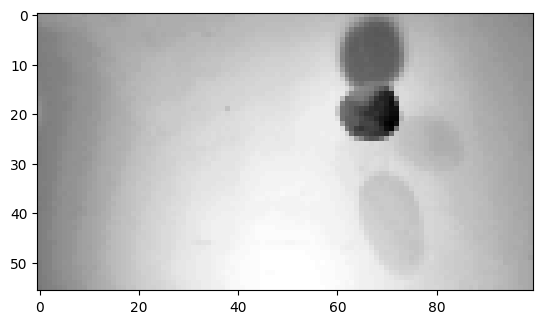

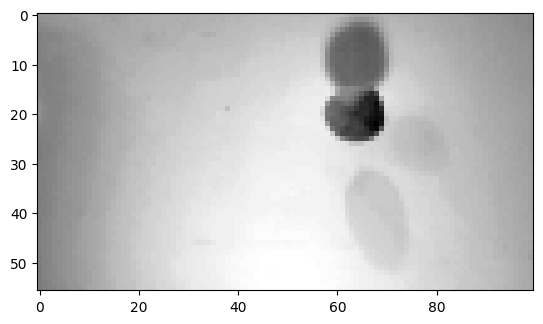

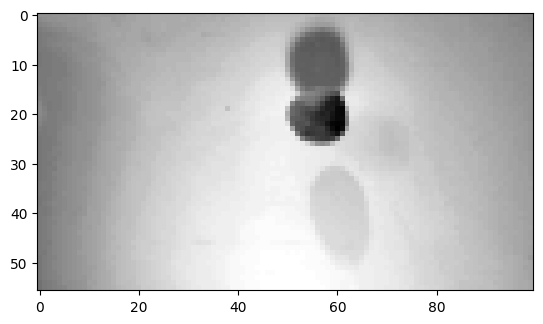

In [5]:
np_frames = np.array(frames)
init = 0
fps = 60
period = 2*fps
print(period)
period = int(period)


plt.imshow(np_frames[2000], cmap='gray')
plt.show()

plt.imshow(np_frames[2012], cmap='gray')
plt.show()
plt.imshow(np_frames[2024], cmap='gray')
plt.show()

In [6]:
print("period:", 137/60)
print("n frames x period:", 137/2)
print("dt: ", 1/60)

period: 2.283333333333333
n frames x period: 68.5
dt:  0.016666666666666666


In [7]:
np_frames = np_frames[::3,:,:]
print(np_frames.shape)

(904, 56, 100)


In [29]:
dataset = []
np_frames = np.array(frames)
print(np_frames.shape)
np_frames = np_frames[22::,:,:]
np_frames = np_frames / 255.0
print("number of frames:", np_frames.shape)
nframes = np_frames.shape[0]
step = 24
max_frames = np_frames.shape[0] - (20*step)
for i in range(max_frames):

    frames_temp = np_frames[i:(i+20*step):step]
    
    dataset.append(np.expand_dims( frames_temp, axis=1))

dataset = np.array(dataset)
print("before subsampling ", dataset.shape)
#dataset = dataset[::2]
print("after subsampling ",dataset.shape)

(2711, 56, 100)
number of frames: (2689, 56, 100)
before subsampling  (2209, 20, 1, 56, 100)
after subsampling  (2209, 20, 1, 56, 100)


In [31]:
np.save('Data/Data_rebuttal/pendulum_real_crop_120_100x50.npy', dataset)

### Model

In [2]:
data_folder = np.load('Data/Data_rebuttal/pendulum_real_crop_120_100x50.npy')


In [4]:
torch.cuda.empty_cache() 
torch.manual_seed(0)


data_train = data_folder
data_train = data_train[::2]
print(data_train.shape)
fr = 60.0
skiped_frames = 1
dt = 0.4
train_dataloader, test_dataloader, train_x, val_x  = loader.getLoader_folder(data_train, split=True)




latentEncoder_I = mainmodel.EndPhys(dt = dt,
                                pmodel = "Damped_oscillation",
                                init_phys = 1.0, 
                                initw=True)

latentEncoder_I, log, params  = train.train(latentEncoder_I, 
                                train_dataloader, 
                                test_dataloader,
                                init_phys = 0.09,                                 
                                loss_name='latent_loss')

(1105, 20, 1, 56, 100)
dt 0.4
Using device: cuda


Initial Loss 	 training loss: 5.388346467699323 	 validation loss: 5.338294744491577
epoch: 50 	 training loss: 0.7484506624085563 	 validation loss: 0.6176682710647583
epoch: 100 	 training loss: 0.7141265869140625 	 validation loss: 0.4635596424341202
epoch: 150 	 training loss: 0.525420755147934 	 validation loss: 0.3329700082540512
epoch: 200 	 training loss: 0.4285317744527544 	 validation loss: 0.3194090574979782
epoch: 250 	 training loss: 0.4851207988602774 	 validation loss: 0.3230533301830292
epoch: 300 	 training loss: 0.21530558168888092 	 validation loss: 0.37003855407238007
epoch: 350 	 training loss: 0.1881451564175742 	 validation loss: 0.4711999297142029
epoch: 400 	 training loss: 0.10685548186302185 	 validation loss: 0.3737107515335083
epoch: 450 	 training loss: 0.07073678608451571 	 validation loss: 0.2086244374513626
epoch: 500 	 training loss: 0.11582894250750542 	 validation loss: 0.32049183547496796
best model a 1.2210954427719116
best last a 1.177634119987487

### Visualizations

In [29]:
dataloader  = loader.getLoader_folder(data_train, split=False)


z = None

device = "cuda" if torch.cuda.is_available() else "cpu"

best_model = mainmodel.EndPhys(dt = dt,  
                                pmodel = "Damped_oscillation",
                                init_phys = 1.0, 
                                initw=True)

checkpoint = torch.load('best-model-parameters.pt')
best_model.load_state_dict(checkpoint)
best_model.to(device)

z = None
X = []

for data in dataloader:

    input_Data, out_Data = data

    x0 = input_Data

    x0 = x0.to(device=device, dtype=torch.float)

    x2 = out_Data.to(device=device, dtype=torch.float)

    outputs = best_model(x0)
    z2_encoder, z2_phys, z3=outputs

    if z is None:
        z = z2_encoder.detach().cpu().numpy()[0][0]
    else:
        z = np.vstack((z,z2_encoder.detach().cpu().numpy()[0][0]))

dt 0.4


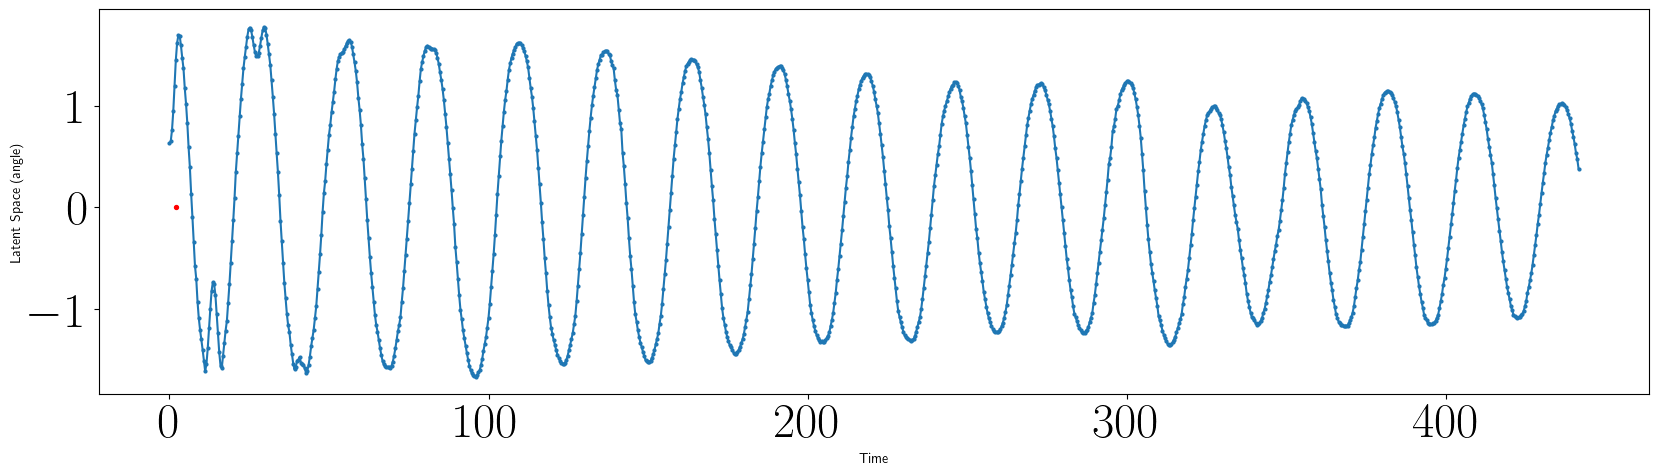

In [30]:
plt.figure(figsize=(20,5))
time = np.arange(z.shape[0])
plt.scatter(time*dt, z, label='real',s=4)
plt.plot(time*dt, z, label='real')
plt.scatter(2.0, 0, color = "red",s=8)
plt.xlabel('Time')
plt.ylabel('Latent Space (angle)')
plt.show()

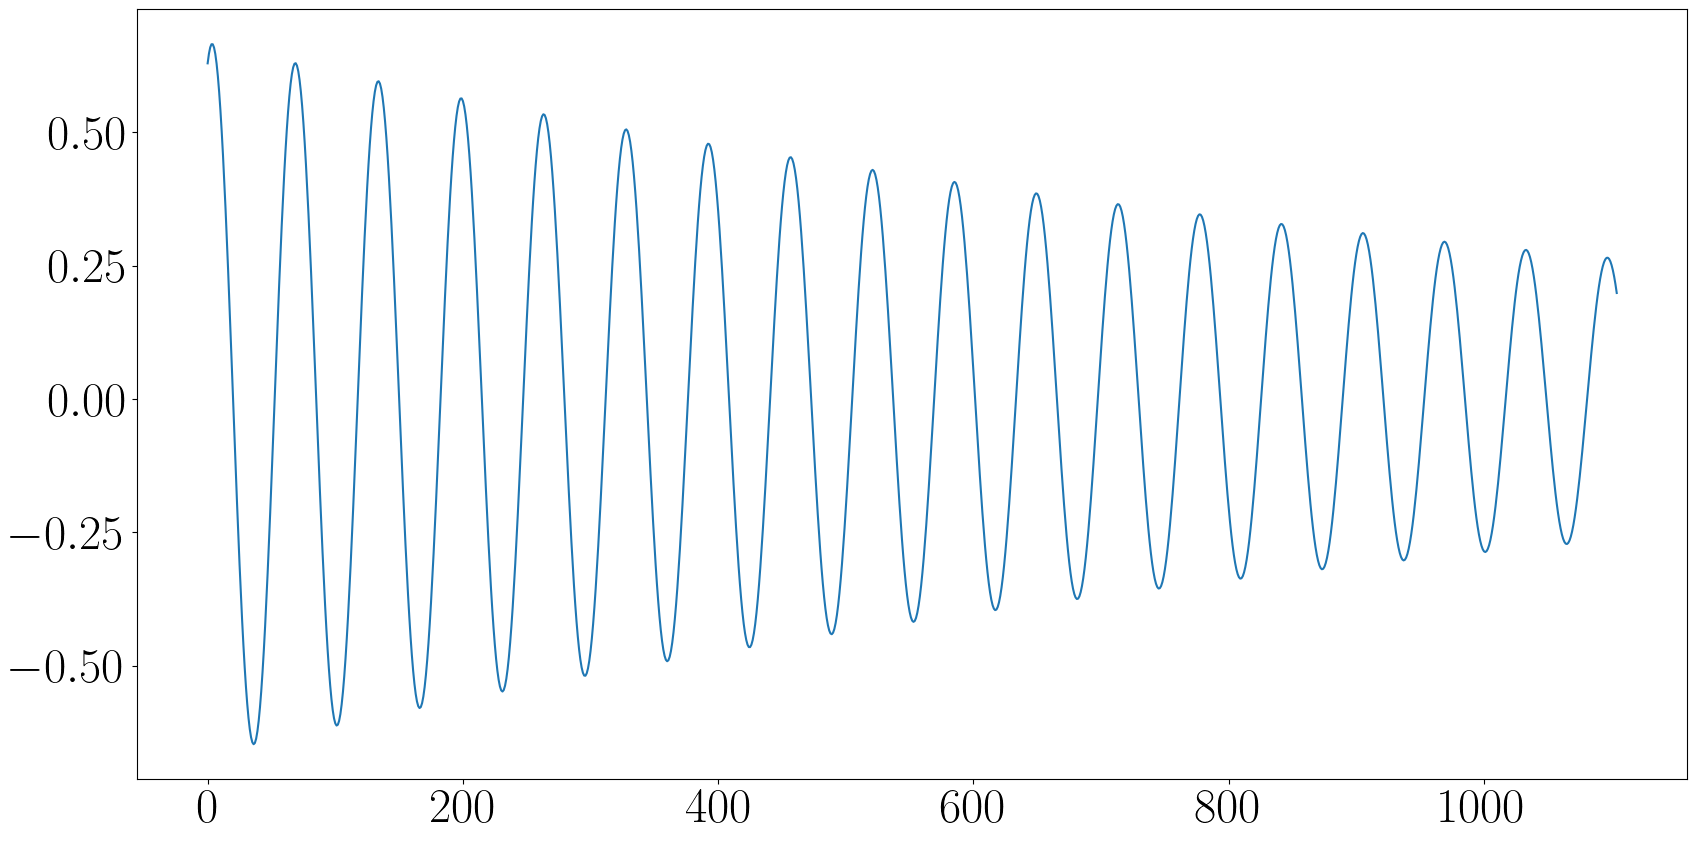

In [31]:
z0 = z[0]
z1 = z[1]

def damped_oscillation(steps, dt, z0, z1, a, b):

    z_ode = []
    z_ode.append(z0)
    z_ode.append(z1)

    for i in range(steps):
        z2 = 2*z1 - z0 - dt*( a*(z1-z0) + dt*b*np.sin(z1)      )
        z_ode.append(z2)
        z0 = z1
        z1 = z2

    return np.array(z_ode)

z_ode = damped_oscillation(z.shape[0]-2, 1/30, z0, z1, 0.05, 8.8)
z_ode = np.array(z_ode[:,0])
time_ode = np.arange(z.shape[0])/30
plt.figure(figsize=(20,10))
plt.plot(time,z_ode)
plt.show()


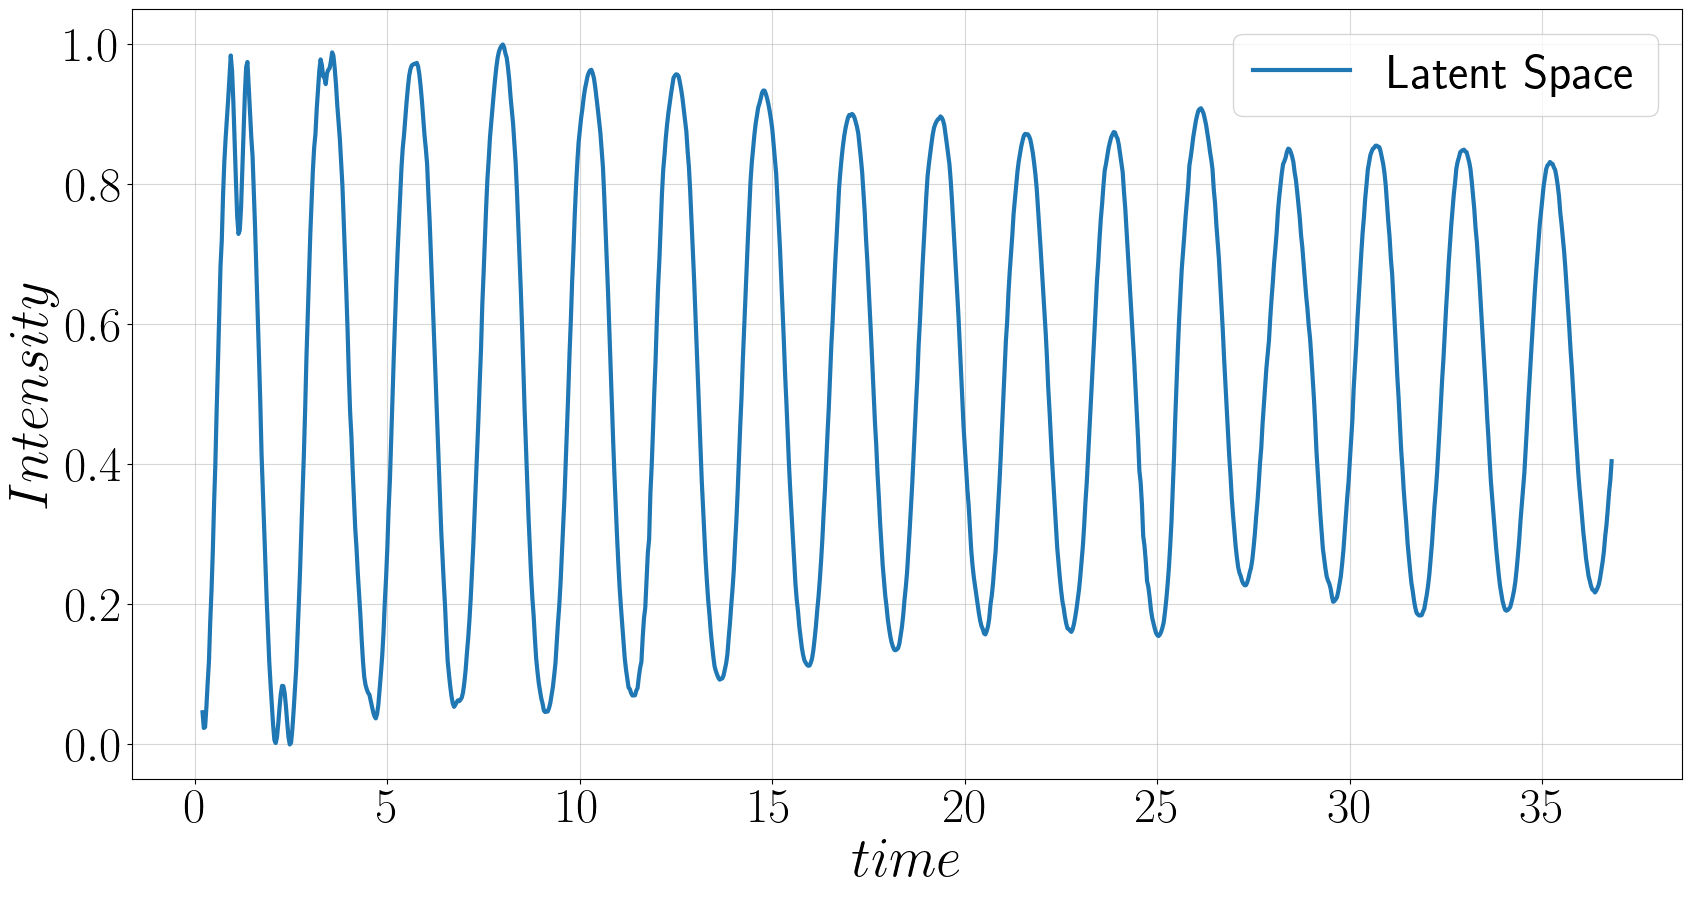

In [33]:
def exp2fit(x, a, b, c):
    return  np.exp(-b * x)*np.cos(a*x+np.pi*4)


def normalize(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))

time = np.arange(z.shape[0])/30
z_fit = exp2fit(time, np.sqrt(8.8), 0.05/2, 0.0)


time = time
z_norm = -z
z_fit = -z_fit

#ys_crop = ys[20:120]

z_norm = normalize(z_norm)
z_fit = normalize(z_fit)
z_ode = normalize(z_ode)

time_crop = time

plt.figure(figsize=(20,10))
plt.rcParams['text.usetex'] = True
plt.plot(time[6:], z_norm[6:], label=r'Latent Space', linewidth=3 )
#plt.plot( time_ode,z_ode ,'--', label=r'Real', linewidth=2) 
#plt.plot(time, z_fit, label=r'Fitted', linewidth=3, alpha=0.5) 
plt.legend(fontsize="35")
plt.xlabel(r'$time$', fontsize=40)
plt.ylabel(r'$Intensity$', fontsize=40)
plt.tick_params(axis='y', which='major')#, pad=25)
plt.rc('xtick', labelsize=35)
plt.rc('ytick', labelsize=35)
plt.grid(True, alpha=0.5)

plt.savefig('Data/Data_rebuttal/fit_pendulum.png', dpi  = 300)

plt.show()


## Crazy experiment

### vrideo preparation

In [148]:
from asyncio import sleep

from wizcon import wizcon
import pywizlight.scenes
from pywizlight.bulb import wizlight, PilotBuilder

In [143]:
ip = "192.168.200.243"



In [153]:
light = wizcon.Wizcon(ip)


await light.set_brightness(10)
await light.turn_bulb_on()
# wait 3 seconds
await sleep(0.5)
# change the brightness to 100
await light.turn_bulb_off()

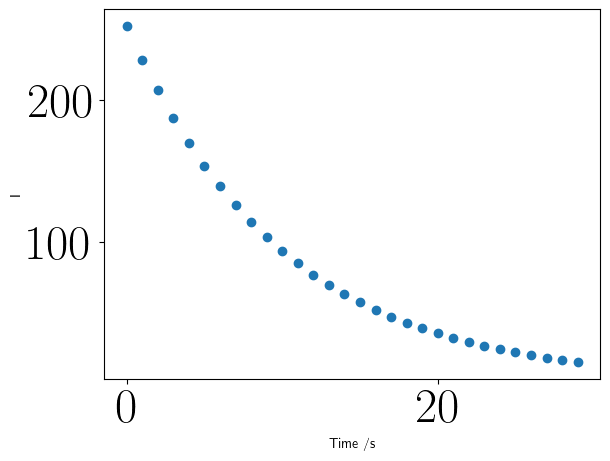

In [215]:
dt = 0.1
t = np.arange(0, 30, 1)
I = 250*np.exp(-t * 0.1) +2
plt.figure()
plt.scatter(t, I)
plt.xlabel('Time /s')
plt.ylabel('I')
plt.show()

In [184]:

print(I.max())
print(I.min())

252.0
15.755805014101803


In [217]:
await sleep(5)

await light.set_brightness(255)
await light.turn_bulb_on()

for i in I:
    await sleep(2)
    await light.set_brightness(int(i))
await sleep(1)
await light.turn_bulb_off()

### Data preparation

In [218]:
import cv2

# load video from folder using opencv


video = cv2.VideoCapture('Data/Data_rebuttal/CustomI/exp3.mp4')
new_width, new_height = 56,100


new_dim = (new_width, new_height)

frames = []
while True:
    ret, frame = video.read()
    
    if ret == False:
        break
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    resized_img = cv2.resize(frame, new_dim, interpolation= cv2.INTER_CUBIC )
    #resized_img = frame
    frames.append(resized_img)
video.release()

print(len(frames))

video = cv2.VideoCapture('Data/Data_rebuttal/CustomI/exp3.mp4')
# Find OpenCV version
(major_ver, minor_ver, subminor_ver) = (cv2.__version__).split('.')

# With webcam get(CV_CAP_PROP_FPS) does not work.
# Let's see for ourselves.

if int(major_ver)  < 3 :
    fps = video.get(cv2.cv.CV_CAP_PROP_FPS)
    print("Frames per second using video.get(cv2.cv.CV_CAP_PROP_FPS): {0}".format(fps))
else :
    fps = video.get(cv2.CAP_PROP_FPS)
    print("Frames per second using video.get(cv2.CAP_PROP_FPS) : {0}".format(fps))

1713
Frames per second using video.get(cv2.CAP_PROP_FPS) : 30.0


120


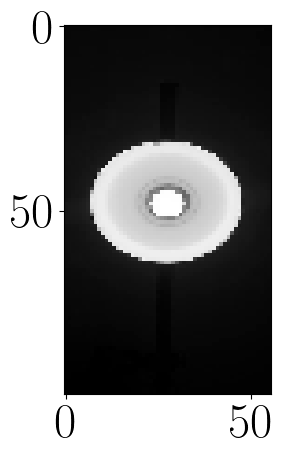

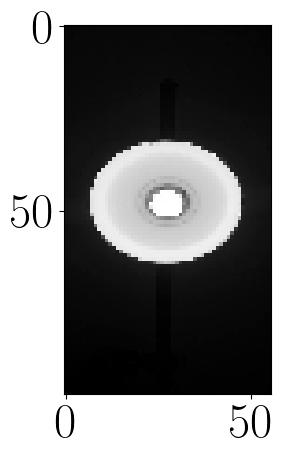

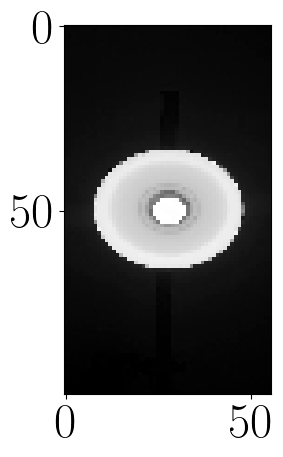

In [219]:
np_frames = np.array(frames)
init = 0
fps = 60
period = 2*fps
print(period)
period = int(period)


plt.imshow(np_frames[0], cmap='gray')
plt.show()

plt.imshow(np_frames[10], cmap='gray')
plt.show()
plt.imshow(np_frames[300], cmap='gray')
plt.show()

In [224]:
dataset = []
np_frames = np.array(frames)
np_frames = np_frames
print(np_frames.shape)
np_frames = np_frames / 255.0
print("number of frames:", np_frames.shape)
nframes = np_frames.shape[0]
step = 6
max_frames = np_frames.shape[0] - (15*step)
for i in range(max_frames):

    frames_temp = np_frames[i:(i+15*step):step]
    
    dataset.append(np.expand_dims( frames_temp, axis=1))

print(len(dataset))

(1713, 100, 56)
number of frames: (1713, 100, 56)
1623


In [225]:
np.save('Data/Data_rebuttal/customExp.npy', dataset)

### data evaluation

(1668, 15, 1, 100, 56)


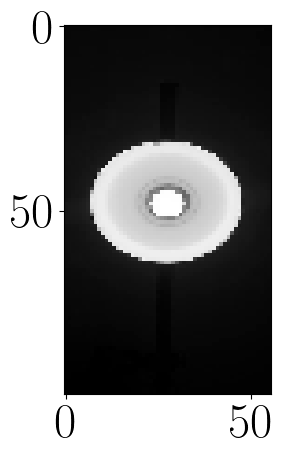

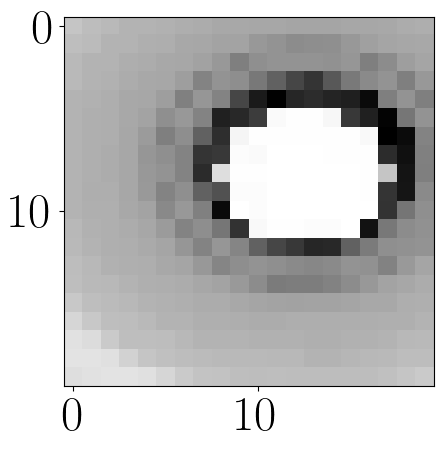

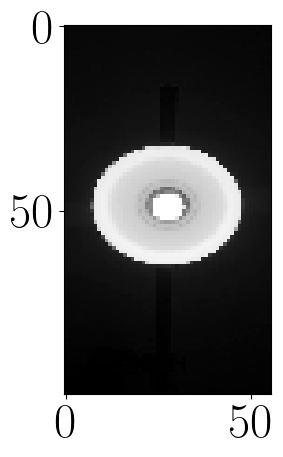

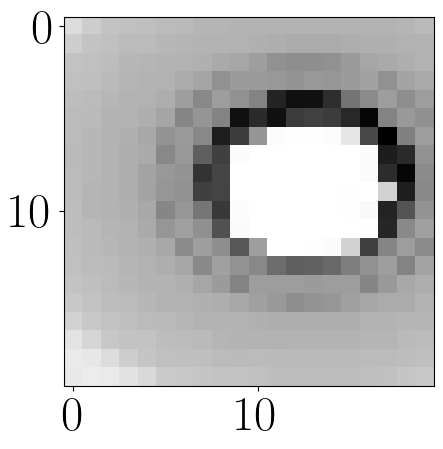

In [222]:
data_folder = np.load('Data/Data_rebuttal/customExp.npy', allow_pickle=True)
print(data_folder.shape)

for i in range(2):
    plt.imshow(data_folder[i*200][0][0], cmap='gray')
    
    plt.show()

    sub_image = data_folder[i*200,0,0, 40:60, 15:35]
    plt.imshow(sub_image, cmap='gray')
    plt.show()


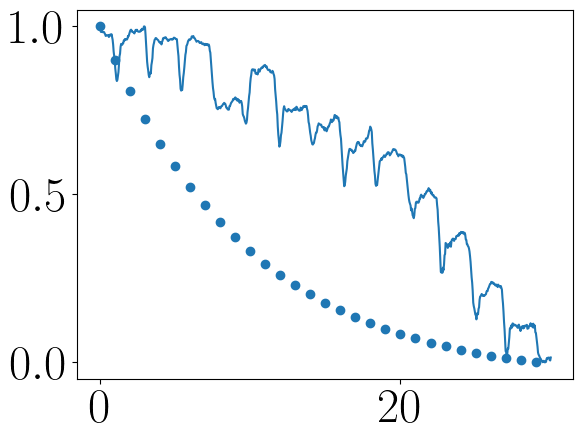

In [223]:
mean_list = []
for i in range(data_folder.shape[0]):
    mean_list.append(np.mean(data_folder[i,0,0, 40:60, 15:35]))



dt = 0.1
t = np.arange(0, 30, 1)
I = 0.1*np.exp(-t * 0.1) +0.5

t1 = np.linspace(0, 30, 850)

norm_I = (I - np.min(I)) / (np.max(I) - np.min(I))
norm_mean = (mean_list[150:1000] - np.min(mean_list[150:1000])) / (np.max(mean_list[150:1000]) - np.min(mean_list[150:1000]))

plt.plot(t1,norm_mean)
plt.scatter(t, norm_I)
plt.show()

### Model

In [233]:
torch.cuda.empty_cache() 
torch.manual_seed(42)


data_folder = np.load('Data/Data_rebuttal/customExp.npy', allow_pickle=True)
data_train = data_folder
# print max
print(np.max(data_train))
print(data_train.shape)

dt = 6/30
train_dataloader, test_dataloader, train_x, val_x  = loader.getLoader_folder(data_train, split=True)




latentEncoder_I = mainmodel.EndPhys(dt = dt,
                                pmodel = "dyn_1storder",
                                init_phys = 1.0, 
                                initw=True)

latentEncoder_I, log, params  = train.train(latentEncoder_I, 
                                train_dataloader, 
                                test_dataloader,
                                init_phys = 1.0,                                 
                                loss_name='latent_loss')

1.0
(1623, 15, 1, 100, 56)
dt 0.2
Using device: cuda


Initial Loss 	 training loss: 4.82288308370681 	 validation loss: 4.796597321828206
epoch: 10 	 training loss: 0.3155131630954288 	 validation loss: 0.961802842716376
epoch: 20 	 training loss: 0.08918331119985808 	 validation loss: 0.15686856396496296
epoch: 30 	 training loss: 0.06649065944587901 	 validation loss: 0.028037063622226317
epoch: 40 	 training loss: 0.10447467619641906 	 validation loss: 0.028052907592306536
epoch: 50 	 training loss: 0.031696499059242864 	 validation loss: 0.045212740854670606
epoch: 60 	 training loss: 1.6233998237266427 	 validation loss: 0.42800937592983246
epoch: 70 	 training loss: 0.017582165565164315 	 validation loss: 0.016588677186518908
epoch: 80 	 training loss: 0.018956345905150686 	 validation loss: 0.02443127365161975
epoch: 90 	 training loss: 0.026831461848425015 	 validation loss: 0.01972868270240724
epoch: 100 	 training loss: 0.023451469306434904 	 validation loss: 0.4278115324365596
best model a 0.019234858453273773
best last a 0.017

In [234]:
dataloader  = loader.getLoader_folder(data_train, split=False)

z = None

device = "cuda" if torch.cuda.is_available() else "cpu"

best_model = mainmodel.EndPhys(dt = dt,
                    pmodel = "dyn_1storder",
                    init_phys = 1.0, 
                    initw=True)

checkpoint = torch.load('best-model-parameters.pt')
best_model.load_state_dict(checkpoint)
best_model.to(device)

z = None
X = []

for data in dataloader:

    input_Data, out_Data = data

    x0 = input_Data

    x0 = x0.to(device=device, dtype=torch.float)

    x2 = out_Data.to(device=device, dtype=torch.float)

    outputs = best_model(x0)
    #outputs = latentEncoder_I(x0)
    z2_encoder, z2_phys, z3=outputs

    if z is None:
        z = z2_encoder.detach().cpu().numpy()[0][0]
    else:
        z = np.vstack((z,z2_encoder.detach().cpu().numpy()[0][0]))

dt 0.2


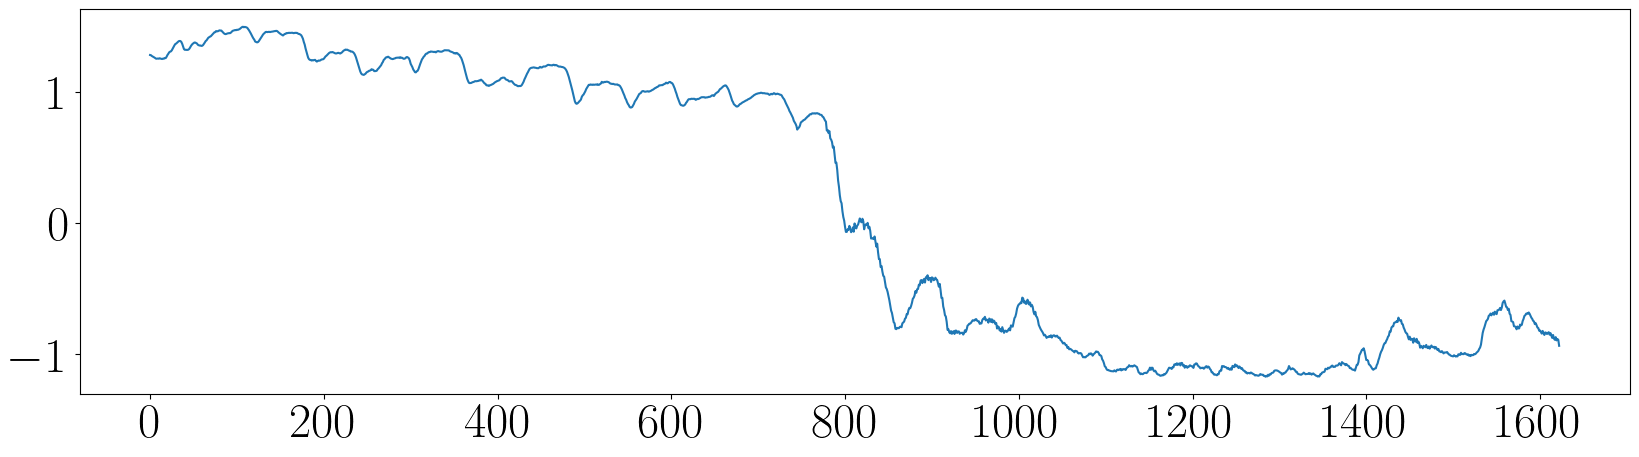

In [235]:
plt.figure(figsize=(20,5))
plt.plot(z)
plt.show()

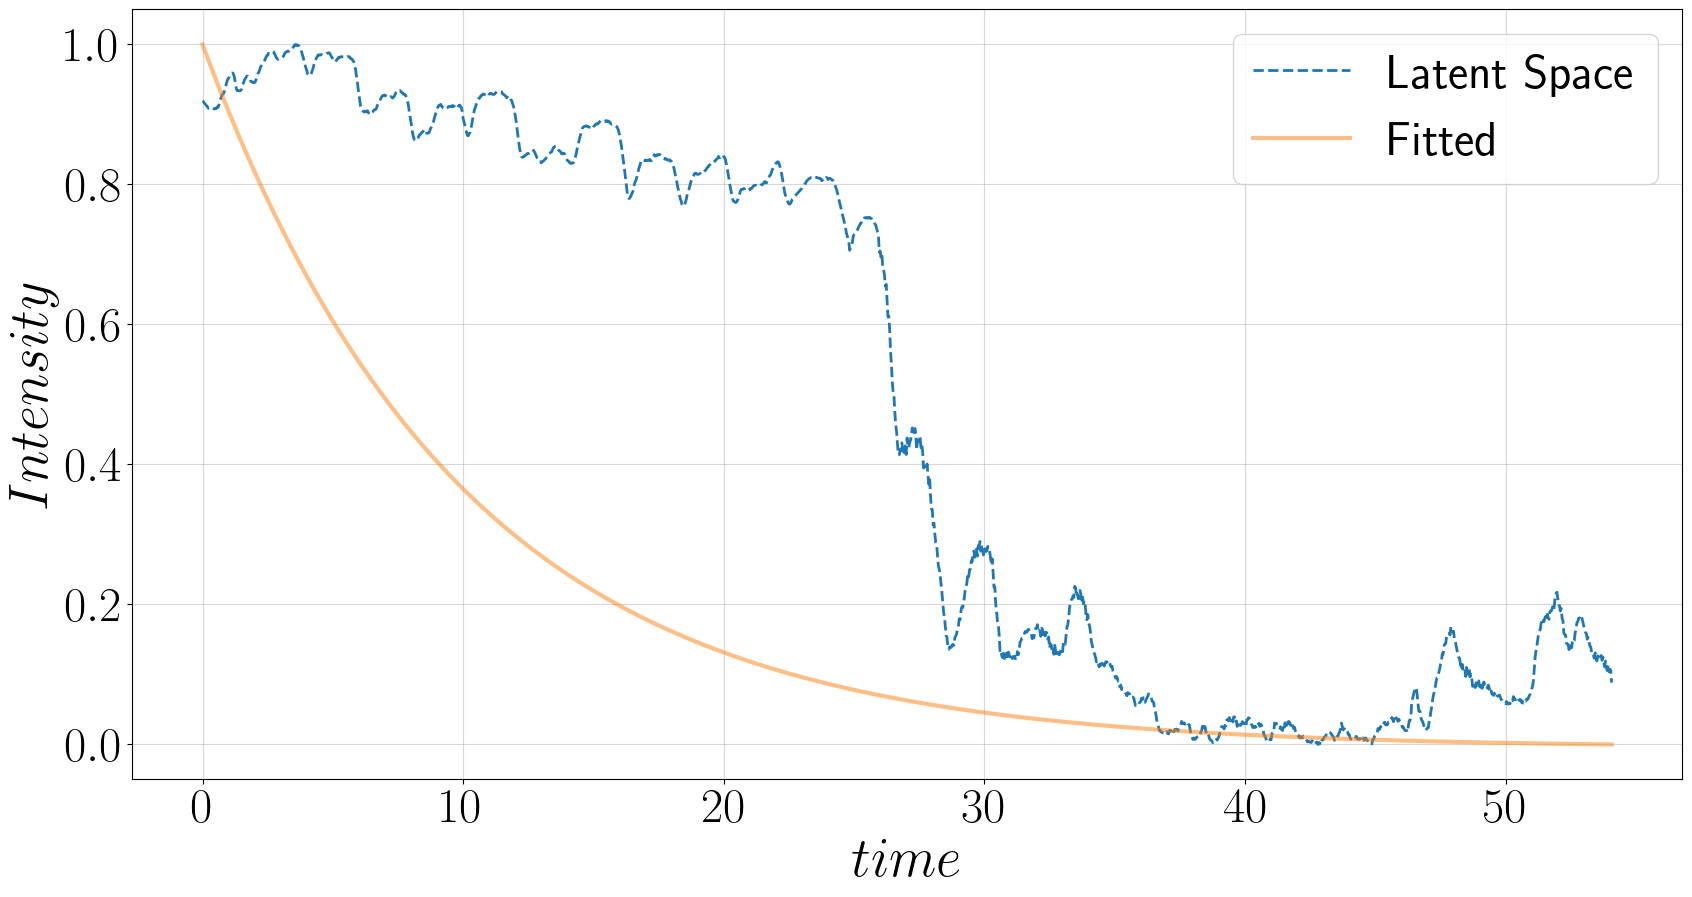

In [239]:
def exp2fit(x, a, b, c):
    return a * np.exp(-b * x) +c

def normalize(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))

time = np.arange(z.shape[0])/30
z_fit = exp2fit(time, 1, 0.1, 0)


time = time
z_norm = z
z_fit = z_fit

ys_crop = mean_list

z_norm = normalize(z_norm)
z_fit = normalize(z_fit)

ys_crop = normalize(ys_crop)


time_crop = time

plt.figure(figsize=(20,10))
plt.rcParams['text.usetex'] = True
plt.plot(time, z_norm,'--', label=r'Latent Space', linewidth=2 )
#plt.plot( time_crop,ys_crop,'--', label=r'Real', linewidth=2) 
plt.plot(time, z_fit, label=r'Fitted', linewidth=3, alpha=0.5) 
plt.legend(fontsize="35")
plt.xlabel(r'$time$', fontsize=40)
plt.ylabel(r'$Intensity$', fontsize=40)
plt.tick_params(axis='y', which='major')#, pad=25)
plt.rc('xtick', labelsize=35)
plt.rc('ytick', labelsize=35)
plt.grid(True, alpha=0.5)

plt.show()

## double pendulum

### Data Gen

In [23]:
#Get theta1 acceleration 
def theta1_acceleration(m1,m2,l1,l2,theta1,theta2,theta1_velocity,theta2_velocity,g):
    mass1 = -g*(2*m1 + m2)*np.sin(theta1)
    mass2 = -m2*g*np.sin(theta1 - 2*theta2)
    interaction = -2*np.sin(theta1 - theta2)*m2*np.cos(theta2_velocity**2*l2 + theta1_velocity**2*l1*np.cos(theta1 - theta2))
    normalization = l1*(2*m1 + m2 - m2*np.cos(2*theta1 - 2*theta2))
    
    theta1_ddot = (mass1 + mass2 + interaction)/normalization
    
    return theta1_ddot

#Get theta2 acceleration
def theta2_acceleration(m1,m2,l1,l2,theta1,theta2,theta1_velocity,theta2_velocity,g):
    system = 2*np.sin(theta1 - theta2)*(theta1_velocity**2*l1*(m1 + m2) + g*(m1 + m2)*np.cos(theta1) + theta2_velocity**2*l2*m2*np.cos(theta1 - theta2))
    normalization = l1*(2*m1 + m2 - m2*np.cos(2*theta1 - 2*theta2))
    
    theta2_ddot = system/normalization
    return theta2_ddot

#Update theta1
def theta1_update(m1,m2,l1,l2,theta1,theta2,theta1_velocity,theta2_velocity,g,time_step):
    #Numerical Integration
    theta1_velocity += time_step*theta1_acceleration(m1,m2,l1,l2,theta1,theta2,theta1_velocity,theta2_velocity,g)
    theta1 += time_step*theta1_velocity
    return theta1, theta1_velocity

#Update theta2
def theta2_update(m1,m2,l1,l2,theta1,theta2,theta1_velocity,theta2_velocity,g,time_step):
    #Numerical Integration
    theta2_velocity += time_step*theta2_acceleration(m1,m2,l1,l2,theta1,theta2,theta1_velocity,theta2_velocity,g)
    theta2 += time_step*theta2_velocity
    return theta2, theta2_velocity

#Run full double pendulum
def double_pendulum(m1,m2,l1,l2,theta1,theta2,theta1_velocity,theta2_velocity,g,time_step,time_span):
    theta1_list = [theta1]
    theta2_list = [theta2]
    
    for t in time_span:
        theta1, theta1_velocity = theta1_update(m1,m2,l1,l2,theta1,theta2,theta1_velocity,theta2_velocity,g,time_step)
        theta2, theta2_velocity = theta2_update(m1,m2,l1,l2,theta1,theta2,theta1_velocity,theta2_velocity,g,time_step)

        theta1_list.append(theta1)
        theta2_list.append(theta2)
    
    x1 = l1*np.sin(theta1_list) #Pendulum 1 x
    y1 = -l1*np.cos(theta1_list) #Pendulum 1 y

    x2 = l1*np.sin(theta1_list) + l2*np.sin(theta2_list) #Pendulum 2 x
    y2 = -l1*np.cos(theta1_list) - l2*np.cos(theta2_list) #Pendulum 2 y
    
    return x1,y1,x2,y2, theta1_list, theta2_list

In [50]:
#Define system parameters
g = 9.8 #m/s^2

m1 = 1 #kg
m2 = 1 #kg

l1 = 1 #m
l2 = 1 #m

theta1 = np.radians(90)
theta2 = np.radians(45)

theta1_velocity = 0 #m/s
theta2_velocity = 0 #m/s

theta1_list = [theta1]
theta2_list = [theta2]

time_step = 0.1

time_span = np.linspace(0,50,500)
print(time_span[1] - time_span[0])
x1,y1,x2,y2, theta1_list_sim, theta2_list_sim = double_pendulum(m1,m2,l1,l2,theta1,theta2,theta1_velocity,theta2_velocity,g,time_step,time_span)

0.10020040080160321


In [55]:
np.sin(theta2_list_sim[100])

-0.9783340626447687

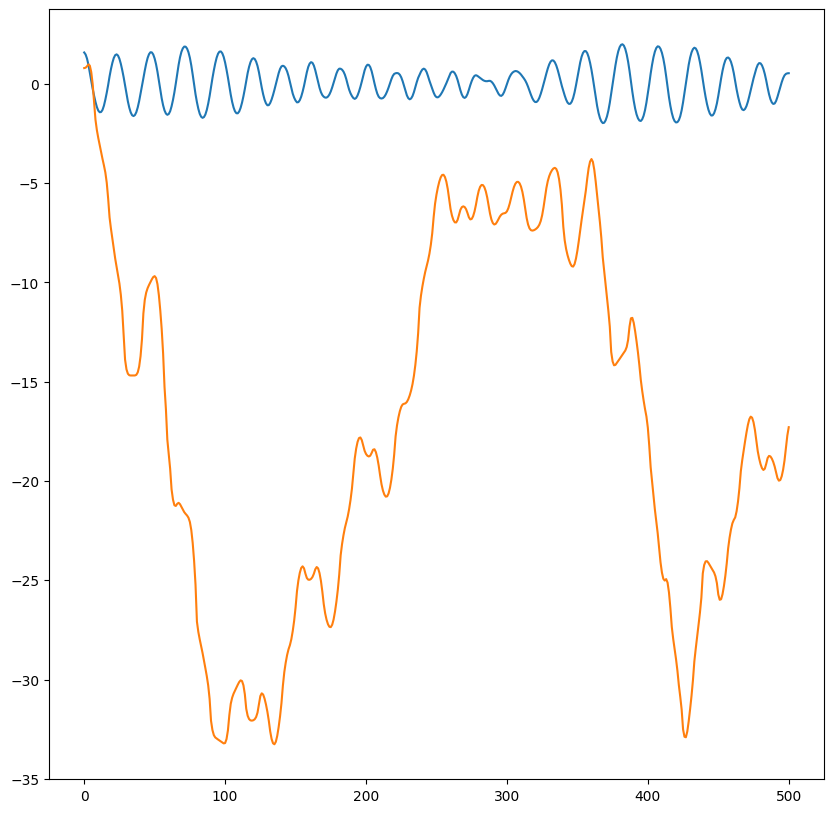

In [51]:
plt.figure(figsize=(10,10))
plt.plot(theta1_list_sim)
plt.plot(theta2_list_sim)
plt.show()

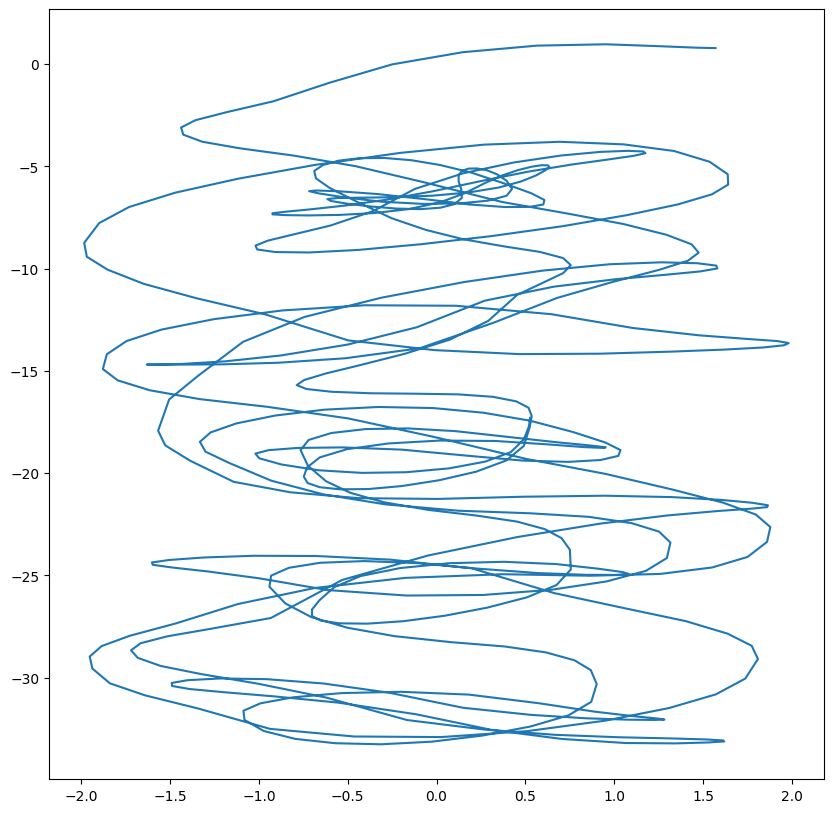

In [26]:
plt.figure(figsize=(10,10))
plt.plot(theta1_list_sim, theta2_list_sim)
plt.show()

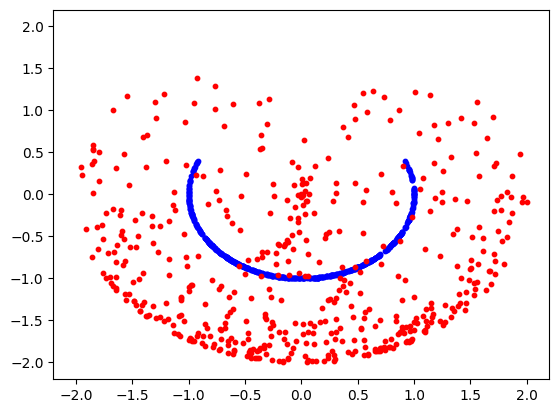

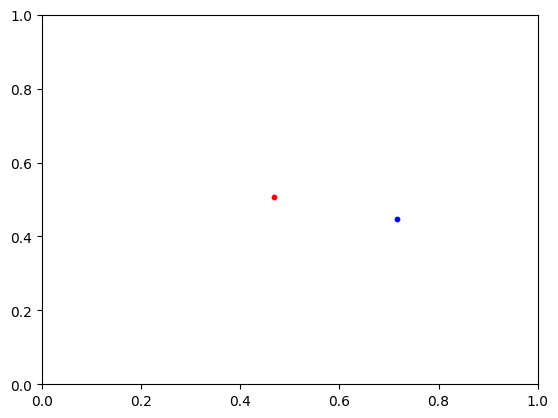

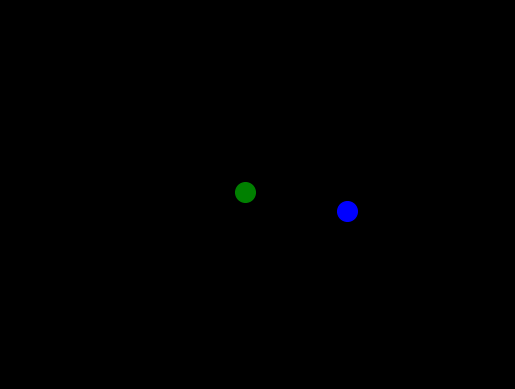

In [57]:
# function to normalize x1 y1 x2 y2 between 0 and 50
def normalize(x1,y1,x2,y2):

    x_global_min = np.min([np.min(x1),np.min(x2)])
    y_global_min = np.min([np.min(y1),np.min(y2)])
    x_global_max = np.max([np.max(x1),np.max(x2)])
    y_global_max = np.max([np.max(y1),np.max(y2)])

    x1 = (x1 - x_global_min)/(x_global_max - x_global_min)
    y1 = (y1 - y_global_min)/(y_global_max - y_global_min)
    x2 = (x2 - x_global_min)/(x_global_max - x_global_min)
    y2 = (y2 - y_global_min)/(y_global_max - y_global_min)



    return x1,y1,x2,y2

x1_n,y1_n,x2_n,y2_n = normalize(x1,y1,x2,y2)

plt.figure()
plt.scatter( x1, y1, s=10,color = 'b')
plt.scatter( x2, y2, s=10,color = 'r')
plt.xlim(-2.2,2.2)
plt.ylim(-2.2,2.2)

plt.show()

plt.figure()
plt.scatter( x1_n[100], y1_n[100], s=10,color = 'b')
plt.scatter( x2_n[100], y2_n[100], s=10,color = 'r')
plt.xlim(0,1)
plt.ylim(0,1)
plt.show()

# save plot to folder in a image of 50x50 pixels
plt.figure(facecolor=(0, 0, 0))

plt.scatter( x1_n[100], y1_n[100], s=200,color = 'b')
plt.scatter( x2_n[100], y2_n[100], s=200,color = 'g')
plt.xlim(-0.1,1.1)
plt.ylim(-0.1,1.1)
plt.axis('off')




plt.savefig('Data/Data_rebuttal/double_pendulum_imgs/all.png', bbox_inches='tight', pad_inches=0, dpi=15)
#plt.close()



In [28]:
for i in range(1,len(x1_n)):
    plt.figure(facecolor=(0, 0, 0))
    plt.scatter( x1_n[i], y1_n[i], s=200,color = 'b')
    plt.scatter( x2_n[i], y2_n[i], s=200,color = 'g')
    plt.xlim(-0.1,1.1)
    plt.ylim(-0.1,1.1)
    plt.axis('off')
    plt.savefig('Data/Data_rebuttal/double_pendulum_imgs/t'+str(i)+'.png', bbox_inches='tight', pad_inches=0, dpi=15)
    plt.close()

In [31]:
# load images from folder iterativelly and save them in a numpy file

import cv2
import numpy as np
import os

path = 'Data/Data_rebuttal/double_pendulum_imgs/'
files = os.listdir(path)
files.sort()

images = []
for file in files:
    #add images wich start with t to the list
    if file[0] == 't':
        #load color image

        img = cv2.imread(path+file)
        images.append(img)

images = np.array(images)
images = images[:,:,:,0:2]
print(images.shape)


(500, 55, 74, 2)


In [32]:
dataset = []

for i in range(0,images.shape[0]-20):
    frames_temp = images[i:(i+20)]
    dataset.append( frames_temp)

dataset = np.array(dataset)
print("before subsampling ", dataset.shape)
np.save('Data/Data_rebuttal/double_pendulum.npy', dataset)



before subsampling  (480, 20, 55, 74, 2)


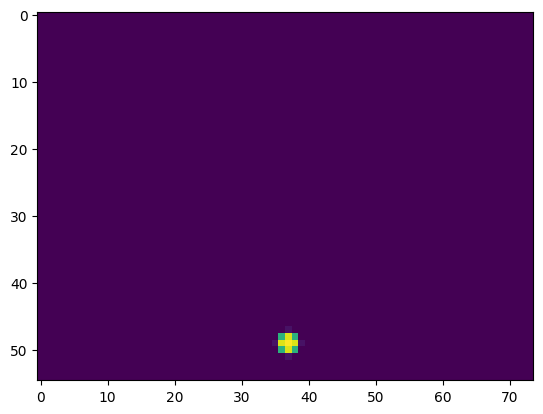

In [33]:
# show firts image
plt.imshow(images[120,:,:,1])
plt.show()

### model

In [80]:
torch.cuda.empty_cache() 
torch.manual_seed(0)

data_folder = np.load('Data/Data_rebuttal/double_pendulum.npy')
data_train = data_folder
if data_train.shape[0] >= 600:
    data_train = data_train[0:600]
data_train = data_train/255.0
print("data train shape: ",data_train.shape)
print(data_train.max())
print(data_train.shape) 


dt = 0.1
print("dt: ",dt)
train_dataloader, test_dataloader, train_x, val_x  = loader.getLoader_folder(data_train, split=True)
latentEncoder = mainmodel.EndPhys_dp(dt = dt, 
                                          in_size=64, 
                                          n_mask = 2, 
                                          in_channels = 2, 
                                          latent_dim=1, 
                                          pmodel = "double_pendulum", 
                                          init_phys = [10.0,1.0], initw=False)
latentEncoder, log  = train.train_dp(latentEncoder, 
                                            train_dataloader, 
                                            test_dataloader,     
                                            init_phys=1.0 ,                           
                                            loss_name='latent_loss_multiple')

data train shape:  (480, 20, 55, 74, 2)
1.0
(480, 20, 55, 74, 2)
dt:  0.1
Using device: cuda


Initial Loss 	 training loss: 11.498802502950033 	 validation loss: 11.413317203521729
epoch: 10 	 training loss: 0.8711112439632416 	 validation loss: 1.192361295223236
epoch: 20 	 training loss: 0.7518414556980133 	 validation loss: 1.2797300815582275
epoch: 30 	 training loss: 0.7379990816116333 	 validation loss: 1.2636978030204773
epoch: 40 	 training loss: 0.7484451234340668 	 validation loss: 1.2223753929138184
epoch: 50 	 training loss: 0.7389798859755198 	 validation loss: 1.2693374156951904
epoch: 60 	 training loss: 0.7368575831254324 	 validation loss: 1.29069983959198
epoch: 70 	 training loss: 0.7426245411237081 	 validation loss: 1.2207492589950562
epoch: 80 	 training loss: 0.7502371867497762 	 validation loss: 1.2082241773605347
epoch: 90 	 training loss: 0.7257722516854604 	 validation loss: 1.3575164675712585
epoch: 100 	 training loss: 0.7331268886725107 	 validation loss: 1.3526456356048584


train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,0.73313
validation_loss,1.35265


best model m2 9.800000190734863
best last m2 9.800000190734863


In [79]:
data_folder = np.load('Data/Data_rebuttal/double_pendulum.npy')
data_train = data_folder
dataloader  = loader.getLoader_folder(data_train, split=False)

z = None

device = "cuda" if torch.cuda.is_available() else "cpu"

best_model = mainmodel.EndPhys_dp(dt = dt, 
                                          in_size=64, 
                                          n_mask = 2, 
                                          in_channels = 2, 
                                          latent_dim=2, 
                                          pmodel = "double_pendulum", 
                                          init_phys = [10.0,1.0], initw=False)

checkpoint = torch.load('best-model-parameters_dp.pt')
best_model.load_state_dict(checkpoint)
best_model.to(device)

z = None
X = []

x1 = []
x2 = []
y1 = []
y2 = []

for data in dataloader:

    input_Data, out_Data = data

    x0 = input_Data

    x0 = x0.to(device=device, dtype=torch.float)

    outputs = best_model(x0)
    #outputs = latentEncoder(x0)
    z2_encoder, z2_phys, z3=outputs
    

    x1.append(z2_encoder[0][0][0].detach().cpu().numpy())
    y1.append(z2_encoder[0][0][1].detach().cpu().numpy())
    x2.append(z2_encoder[0][0][2].detach().cpu().numpy())
    y2.append(z2_encoder[0][0][3].detach().cpu().numpy())
    



RuntimeError: Error(s) in loading state_dict for EndPhys_dp:
	size mismatch for encoder.l3.weight: copying a param with shape torch.Size([1, 100]) from checkpoint, the shape in current model is torch.Size([2, 100]).
	size mismatch for encoder.l3.bias: copying a param with shape torch.Size([1]) from checkpoint, the shape in current model is torch.Size([2]).
	size mismatch for encoder1.l3.weight: copying a param with shape torch.Size([1, 100]) from checkpoint, the shape in current model is torch.Size([2, 100]).
	size mismatch for encoder1.l3.bias: copying a param with shape torch.Size([1]) from checkpoint, the shape in current model is torch.Size([2]).

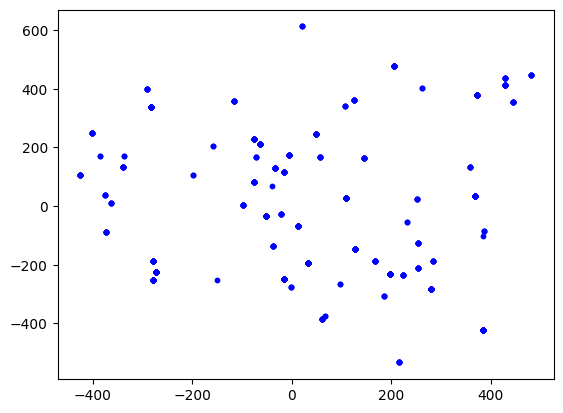

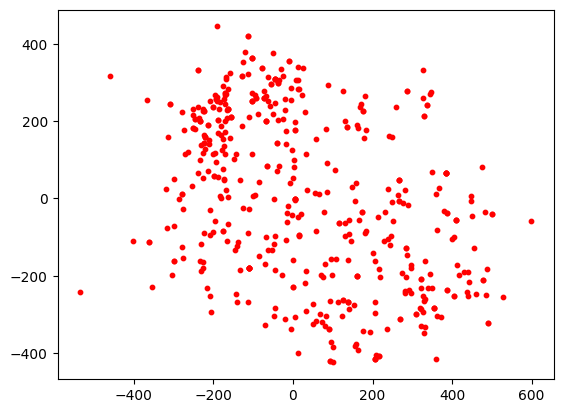

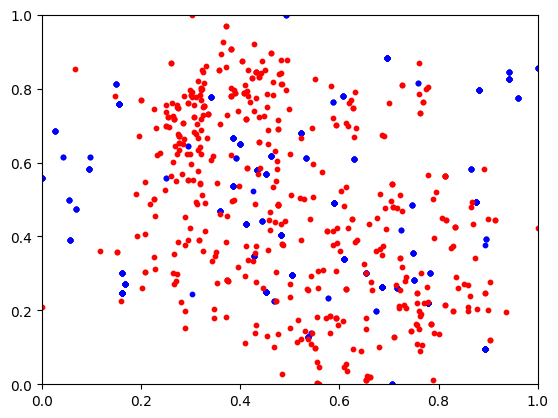

In [49]:
def normalize_01( x1,x2,y1,y2):
    x1_min = np.min(x1)
    x2_min = np.min(x2)
    y1_min = np.min(y1)
    y2_min = np.min(y2)

    x1_max = np.max(x1)
    x2_max = np.max(x2)
    y1_max = np.max(y1)
    y2_max = np.max(y2)
    
    x1 = (x1 - x1_min)/(x1_max - x1_min)
    x2 = (x2 - x2_min)/(x2_max - x2_min)
    y1 = (y1 - y1_min)/(y1_max - y1_min)
    y2 = (y2 - y2_min)/(y2_max - y2_min)
    
    return x1,x2,y1,y2
x1_n,y1_n,x2_n,y2_n = normalize_01(x1,y1,x2,y2)

plt.figure()
plt.scatter( x1, y1, s=10,color = 'b')
plt.show()
plt.figure()
plt.scatter( x2, y2, s=10,color = 'r')
plt.show()

plt.figure()
plt.scatter( x1_n, y1_n, s=10,color = 'b')
plt.scatter( x2_n, y2_n, s=10,color = 'r')
plt.xlim(0,1)
plt.ylim(0,1)
plt.show()

In [81]:
data_folder = np.load('Data/Data_rebuttal/double_pendulum.npy')
data_train = data_folder
dataloader  = loader.getLoader_folder(data_train, split=False)

z = None

device = "cuda" if torch.cuda.is_available() else "cpu"

best_model = mainmodel.EndPhys_dp(dt = dt, 
                                          in_size=64, 
                                          n_mask = 2, 
                                          in_channels = 2, 
                                          latent_dim=1, 
                                          pmodel = "double_pendulum", 
                                          init_phys = [10.0,1.0], initw=False)

checkpoint = torch.load('best-model-parameters_dp.pt')
best_model.load_state_dict(checkpoint)
best_model.to(device)

z = None
X = []

theta1_list = []
theta2_list = []

for data in dataloader:

    input_Data, out_Data = data

    x0 = input_Data

    x0 = x0.to(device=device, dtype=torch.float)

    x2 = out_Data.to(device=device, dtype=torch.float)

    outputs = best_model(x0)
    #outputs = latentEncoder(x0)
    z2_encoder, z2_phys, z3=outputs
    

    theta1_list.append(z2_phys[0][0][0].detach().cpu().numpy())
    theta2_list.append(z2_phys[0][0][1].detach().cpu().numpy())

x1 = 1*np.sin(theta1_list) #Pendulum 1 x
y1 = -1*np.cos(theta1_list) #Pendulum 1 y

x2 = 1*np.sin(theta1_list) + 1*np.sin(theta2_list) #Pendulum 2 x
y2 = -1*np.cos(theta1_list) - 1*np.cos(theta2_list) #Pendulum 2 y
    

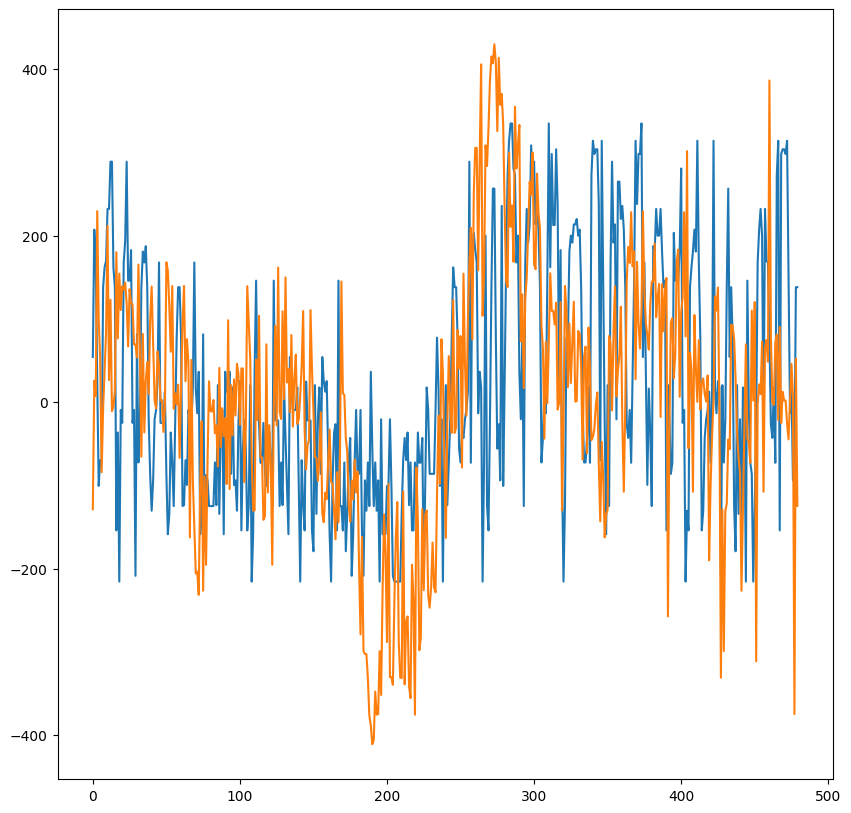

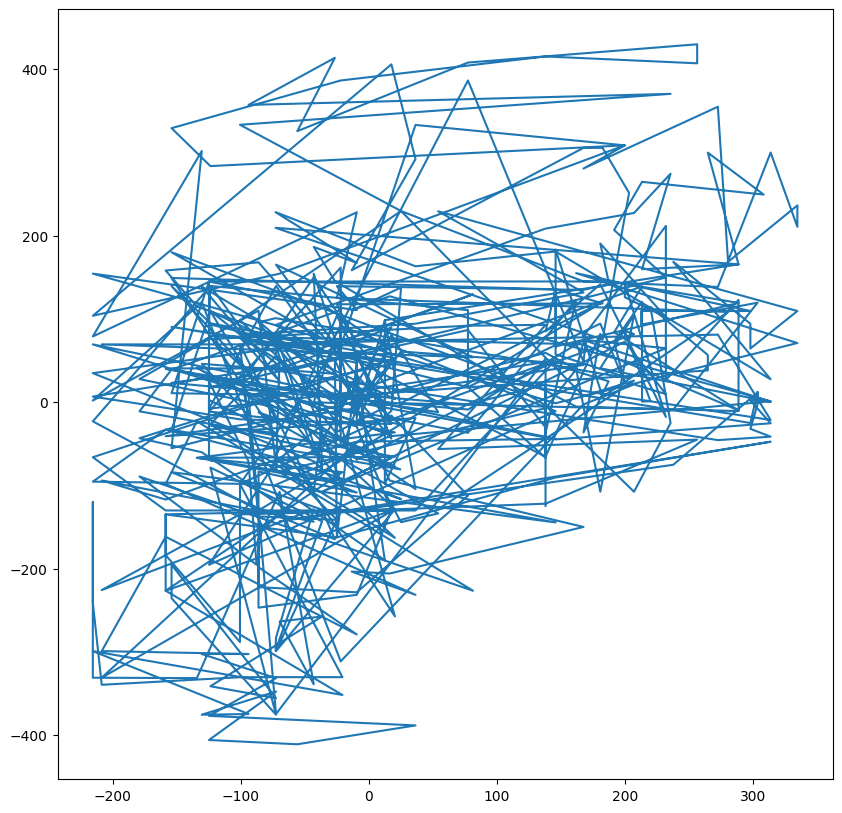

In [82]:
plt.figure(figsize=(10,10))
plt.plot(theta1_list)
plt.plot(theta2_list)
plt.show()

plt.figure(figsize=(10,10))
plt.plot(theta1_list,theta2_list)
plt.show()

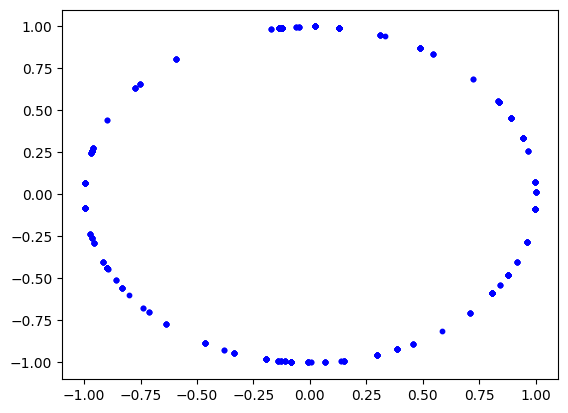

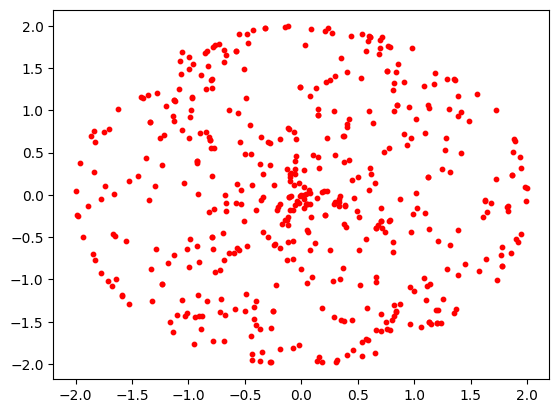

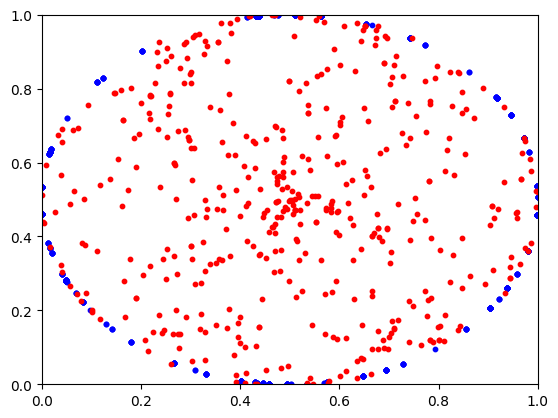

In [83]:
def normalize_01( x1,x2,y1,y2):
    x1_min = np.min(x1)
    x2_min = np.min(x2)
    y1_min = np.min(y1)
    y2_min = np.min(y2)

    x1_max = np.max(x1)
    x2_max = np.max(x2)
    y1_max = np.max(y1)
    y2_max = np.max(y2)
    
    x1 = (x1 - x1_min)/(x1_max - x1_min)
    x2 = (x2 - x2_min)/(x2_max - x2_min)
    y1 = (y1 - y1_min)/(y1_max - y1_min)
    y2 = (y2 - y2_min)/(y2_max - y2_min)
    
    return x1,x2,y1,y2
x1_n,y1_n,x2_n,y2_n = normalize_01(x1,y1,x2,y2)

plt.figure()
plt.scatter( x1, y1, s=10,color = 'b')
plt.show()
plt.figure()
plt.scatter( x2, y2, s=10,color = 'r')
plt.show()

plt.figure()
plt.scatter( x1_n, y1_n, s=10,color = 'b')
plt.scatter( x2_n, y2_n, s=10,color = 'r')
plt.xlim(0,1)
plt.ylim(0,1)
plt.show()

-1.9836726398454902 1.9829842690247972
-33.25785676876248 0.972187758706121


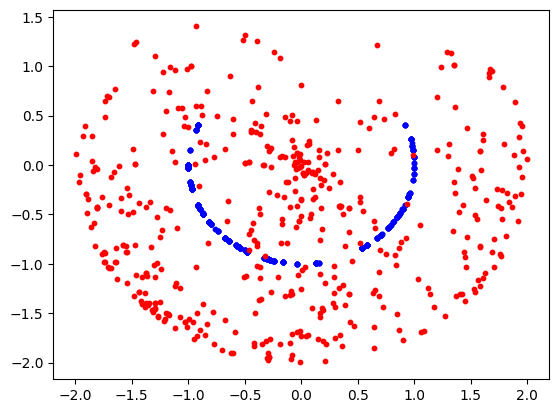

In [84]:
def normalize_sim( theta1_list,theta2_list, theta1_list_sim, theta2_list_sim):
    theta1_min = np.min(theta1_list_sim)
    theta2_min = np.min(theta2_list_sim)
    theta1_max = np.max(theta1_list_sim)
    theta2_max = np.max(theta2_list_sim)

    print(theta1_min,theta1_max)
    print(theta2_min,theta2_max)
    
    m1 = (theta1_max - theta1_min)/(np.max(theta1_list) - np.min(theta1_list))
    m2 = (theta2_max - theta2_min)/(np.max(theta2_list) - np.min(theta2_list))
    b1 = theta1_max - m1*np.max(theta1_list)
    b2 = theta2_max - m2*np.max(theta2_list)

    theta1 = m1*np.array(theta1_list) + b1
    theta2 = m2*np.array(theta2_list) + b2
    
    return theta1, theta2

theta1_list_sim_norm, theta2_list_sim_norm = normalize_sim(theta1_list,theta2_list, theta1_list_sim, theta2_list_sim)

x1 = l1*np.sin(theta1_list_sim_norm) #Pendulum 1 x
y1 = -l1*np.cos(theta1_list_sim_norm) #Pendulum 1 y

x2 = x1 + l2*np.sin(theta2_list_sim_norm) #Pendulum 2 x
y2 = y1 - l2*np.cos(theta2_list_sim_norm) #Pendulum 2 y


plt.figure()
plt.scatter( x1, y1, s=10,color = 'b')
plt.scatter( x2, y2, s=10,color = 'r')

plt.show()


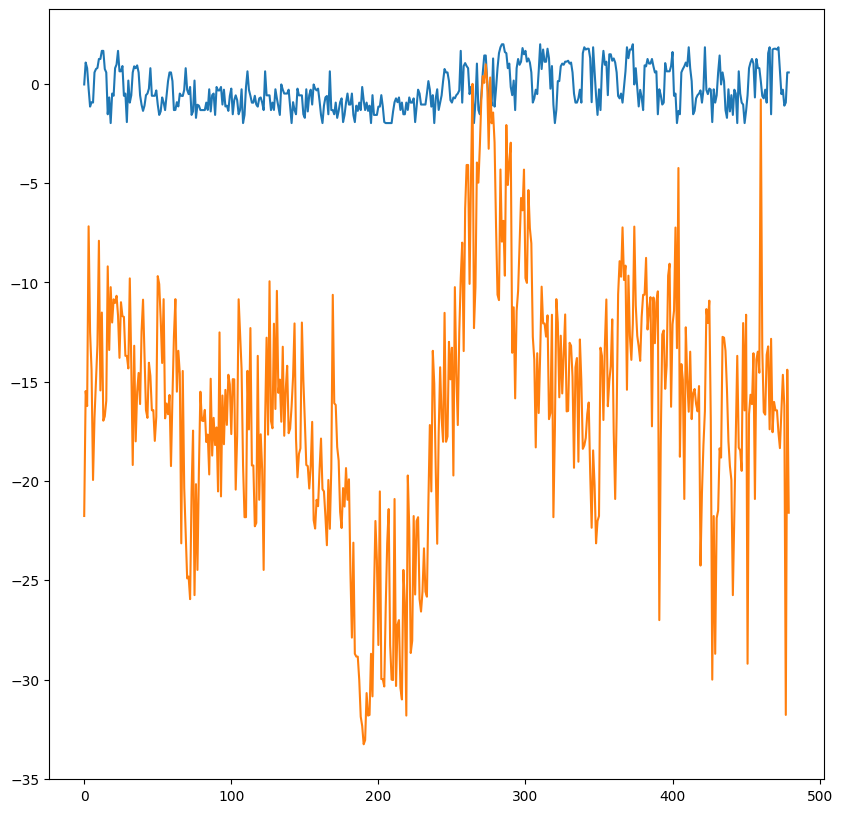

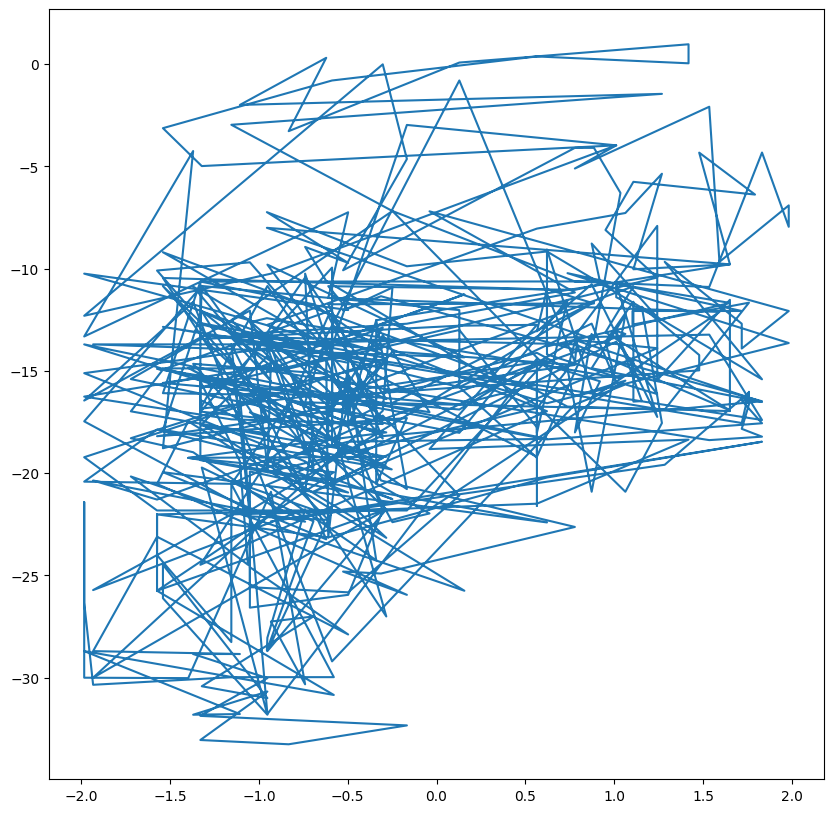

In [85]:
plt.figure(figsize=(10,10))
plt.plot(theta1_list_sim_norm)
plt.plot(theta2_list_sim_norm)
plt.show()

plt.figure(figsize=(10,10))
plt.plot(theta1_list_sim_norm,theta2_list_sim_norm)
plt.show()

In [ ]:
def double_pendulum(m1,m2,l1,l2,theta1,theta2,theta1_velocity,theta2_velocity,g,time_step,time_span):
    theta1_list = [theta1]
    theta2_list = [theta2]
    
    for t in time_span:
        theta1, theta1_velocity = theta1_update(m1,m2,l1,l2,theta1,theta2,theta1_velocity,theta2_velocity,g,time_step)
        theta2, theta2_velocity = theta2_update(m1,m2,l1,l2,theta1,theta2,theta1_velocity,theta2_velocity,g,time_step)

        theta1_list.append(theta1)
        theta2_list.append(theta2)
    
    x1 = l1*np.sin(theta1_list) #Pendulum 1 x
    y1 = -l1*np.cos(theta1_list) #Pendulum 1 y

    x2 = l1*np.sin(theta1_list) + l2*np.sin(theta2_list) #Pendulum 2 x
    y2 = -l1*np.cos(theta1_list) - l2*np.cos(theta2_list) #Pendulum 2 y
    
    return x1,y1,x2,y2